# PyMC3

# setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [3]:
import pymc3 as pm
import arviz as az
import theano 

In [4]:
%matplotlib inline

# simple linear regression

In [5]:
intercept_true = 2
slope_true = -4
sd_true = 5

In [6]:
number_of_points = 1000
X = np.linspace(0, 10, number_of_points)
y = intercept_true + slope_true * X + np.random.normal(scale=sd_true, size=number_of_points)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

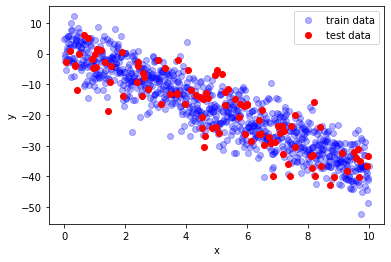

In [8]:
plt.plot(X_train, y_train, 'bo', alpha=0.3)
plt.plot(X_test, y_test, 'ro')
plt.legend(['train data', 'test data']);
plt.xlabel('x');
plt.ylabel('y');

In [9]:
X_shared = theano.shared(np.array(X_train))
y_shared = theano.shared(np.array(y_train))

In [10]:
with pm.Model() as model: 
    # priors 
    intercept = pm.Normal('intercept', 0, sigma=10)
    slope = pm.Normal('slope', 0, sigma=10)
    sd = pm.HalfNormal('sd', sigma=10)
    # likelihood 
    y = slope * X_shared + intercept
    pm.Normal('y', mu=y, sigma=sd, observed=y_shared)
    # inference 
    trace = pm.sample(3000, tune=1000, cores=1, chains=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (3 chains in 1 job)
NUTS: [sd, slope, intercept]
Sampling chain 2, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 848.41it/s]


In [11]:
model.model

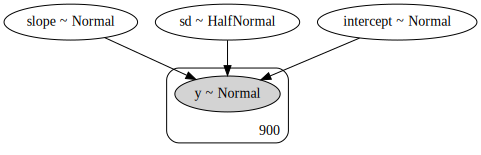

In [12]:
pm.model_to_graphviz(model)

In [13]:
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
intercept  2.119  0.350   1.453    2.755      0.006    0.004    3831.0   
slope     -4.022  0.061  -4.131   -3.904      0.001    0.001    3877.0   
sd         5.150  0.124   4.928    5.396      0.002    0.001    4862.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
intercept  3831.0    3830.0    4222.0    1.0  
slope      3877.0    3878.0    4161.0    1.0  
sd         4849.0    4889.0    4220.0    1.0

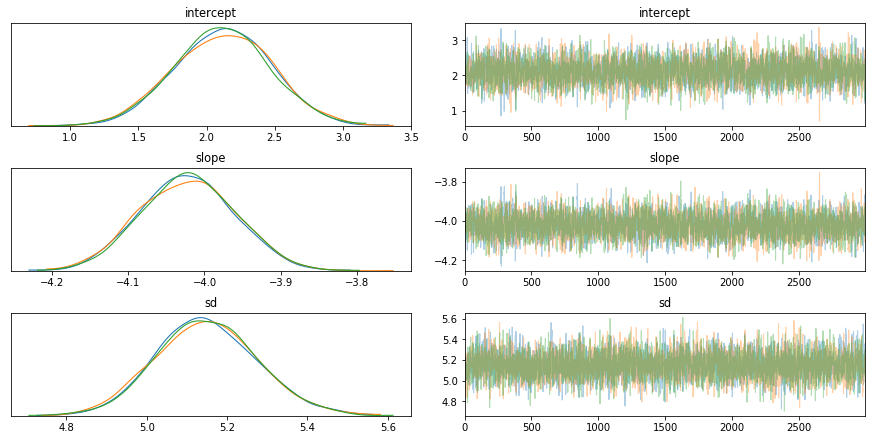

In [14]:
az.plot_trace(trace);

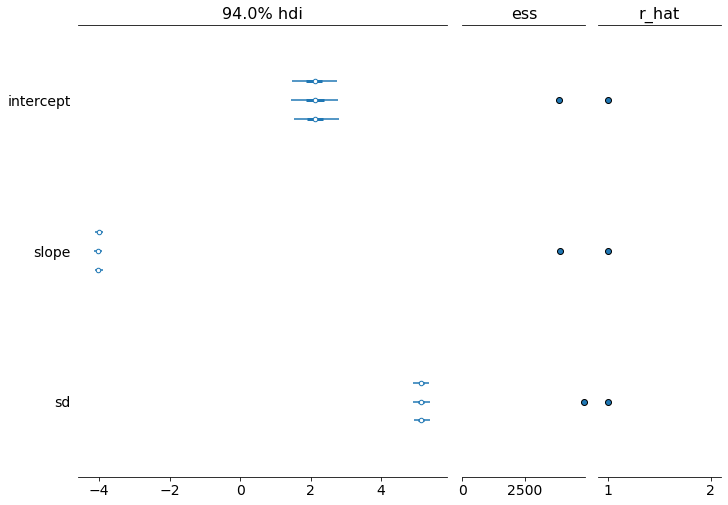

In [15]:
az.plot_forest(trace, r_hat=True, ess=True);

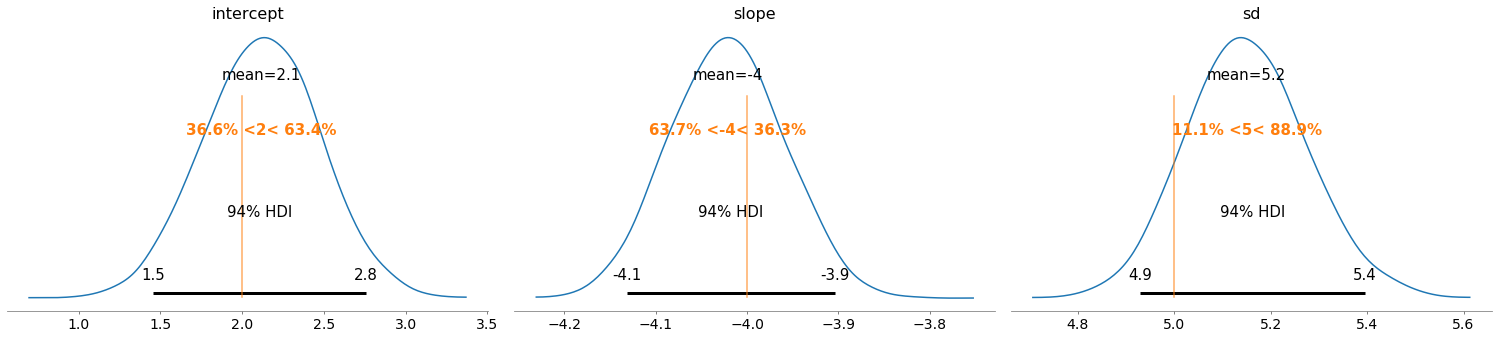

In [16]:
az.plot_posterior(trace, ref_val=[intercept_true,slope_true,sd_true]);

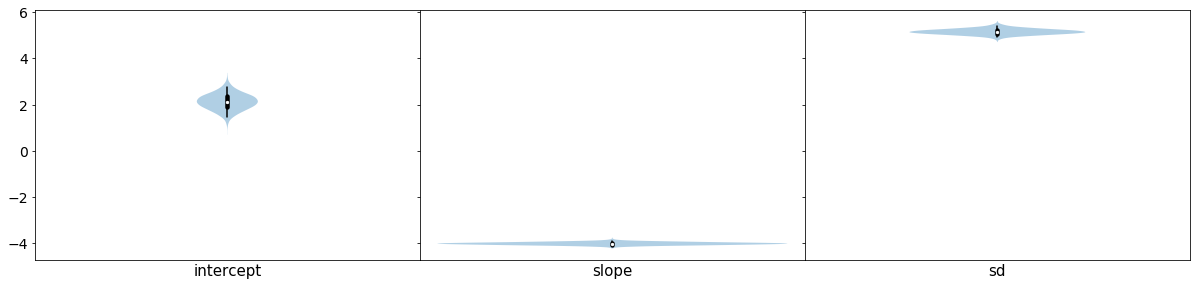

In [17]:
az.plot_violin(trace);

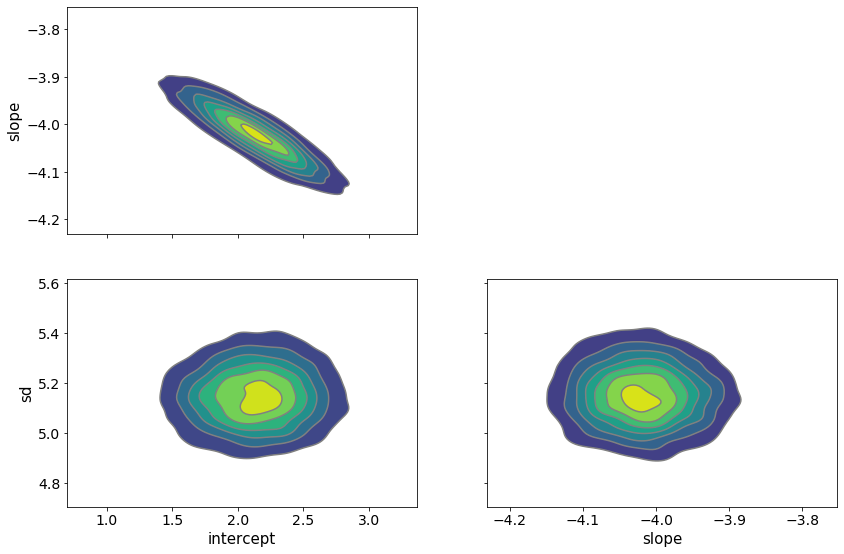

In [18]:
az.plot_pair(trace, kind='kde');

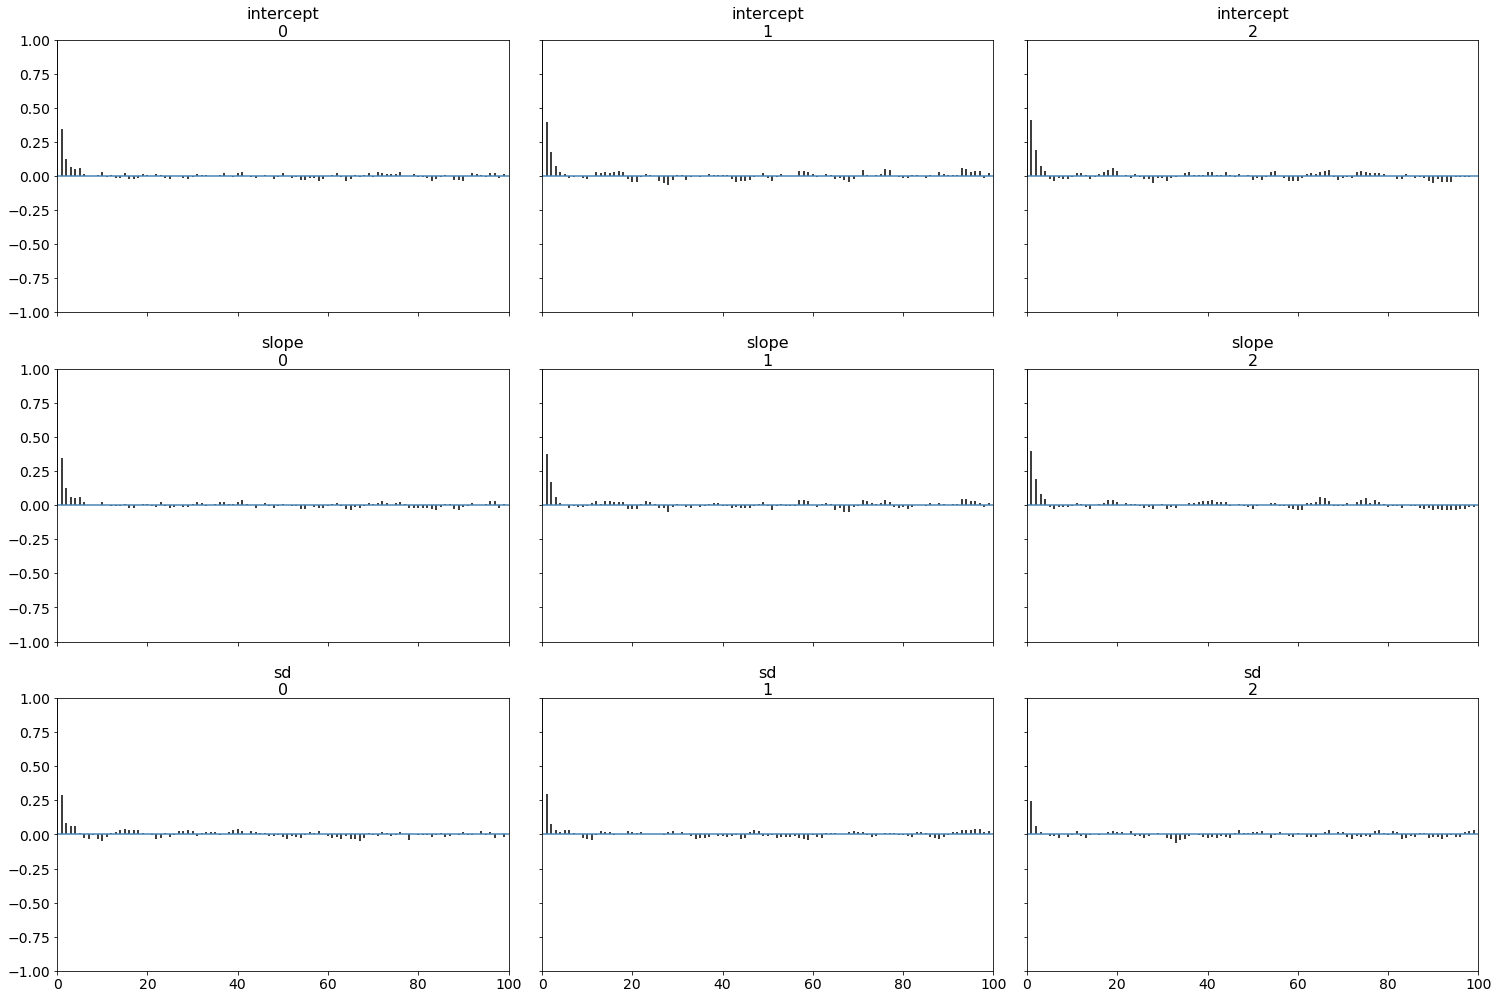

In [19]:
az.plot_autocorr(trace);

In [20]:
X_shared.set_value(X_test)

In [21]:
predictions = pm.sample_posterior_predictive(trace, model=model)

100%|██████████| 9000/9000 [01:35<00:00, 94.38it/s] 


In [22]:
predictions_posterior = predictions['y'].T

Text(0.5, 1.0, 'posterior distribution of first 10 predictions')

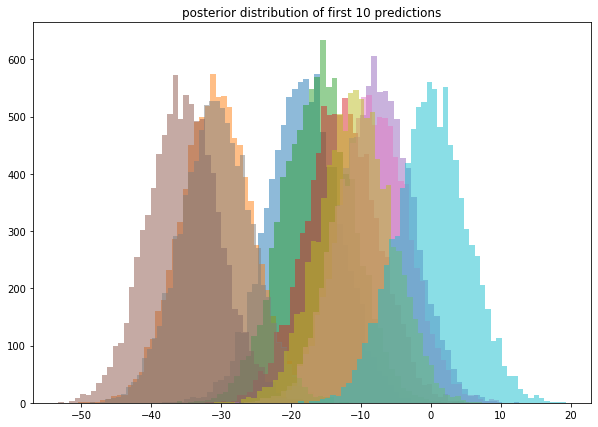

In [23]:
plt.figure(figsize=[10,7])
for x in range(0,10):
    plt.hist(predictions_posterior[x], bins=50, alpha=0.5)
plt.title("posterior distribution of first 10 predictions")

In [24]:
def prediction_intervals(predictions_posterior, percentile):
    predictions = np.array([np.mean(each) for each in predictions_posterior])
    err_down = np.array([np.percentile(each, (100 - percentile) / 2) for each in predictions_posterior])
    err_up = np.array([np.percentile(each, 100 - (100 - percentile) / 2) for each in predictions_posterior])
    return np.transpose(np.array([predictions, err_down, err_up]))

In [25]:
prediction_ints = prediction_intervals(predictions_posterior, percentile=95)

In [26]:
prediction_ints_df = pd.DataFrame(prediction_ints)
prediction_ints_df.columns = ["PREDICTION","LOWER","UPPER"]

In [27]:
actual_prediction_df = pd.DataFrame({'ACTUAL' : y_test}).reset_index(drop=True)

In [28]:
results_df = pd.concat([actual_prediction_df, prediction_ints_df], axis=1)

In [29]:
results_df

ACTUAL  PREDICTION      LOWER      UPPER
0  -25.937612  -18.248745 -28.286837  -8.222322
1  -15.748976  -30.728871 -40.573273 -20.677912
2  -24.313335  -16.191879 -26.372332  -6.318425
3  -12.874595  -12.746865 -22.962526  -2.765442
4   -2.619990   -7.661929 -17.600902   2.299053
..        ...         ...        ...        ...
95 -27.012926  -24.841078 -34.905998 -14.842508
96 -14.806184  -20.382696 -30.398403  -9.999123
97 -26.289003  -21.682677 -31.671095 -11.356971
98  -6.298194   -8.352331 -18.646050   1.428160
99  -3.988678   -4.006499 -14.100028   6.097512

[100 rows x 4 columns]

In [30]:
r2_score(results_df.ACTUAL, results_df.PREDICTION)

0.7596089176930458

In [31]:
results_df_sorted = results_df.sort_values(by='ACTUAL').reset_index(drop=True)

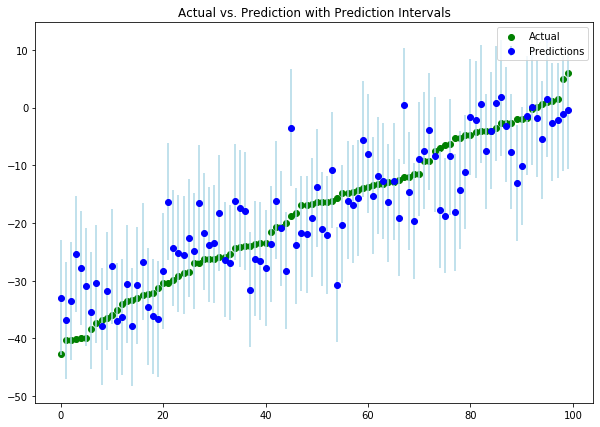

In [32]:
plt.figure(figsize=[10,7])
plt.scatter(results_df_sorted.index,
            results_df_sorted.ACTUAL,
            color='green')
plt.errorbar(results_df_sorted.index,
             results_df_sorted.PREDICTION,
             yerr=[results_df_sorted.PREDICTION - results_df_sorted.LOWER, 
                   results_df_sorted.UPPER - results_df_sorted.PREDICTION],
             ecolor='lightblue', 
             fmt='bo',
             elinewidth=0)
plt.title("Actual vs. Prediction with Prediction Intervals")
plt.legend(['Actual','Predictions'])

In [33]:
correct = 0
for each_row in results_df.itertuples():
    if each_row.LOWER <= each_row.ACTUAL <= each_row.UPPER:
        correct += 1
print(correct/results_df.shape[0])

0.89


# multiple linear regression

In [34]:
from sklearn.datasets import load_boston

In [35]:
boston = load_boston()
features = boston["data"]
feature_names = boston["feature_names"]
labels = boston["target"]

In [36]:
df = pd.DataFrame(features)
df.columns = feature_names 
df["LABEL"] = labels

In [37]:
X = df.drop(columns=["LABEL"])
y = df["LABEL"]

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [39]:
X_shared = theano.shared(np.array(X_train))
y_shared = theano.shared(np.array(y_train))

In [40]:
with pm.Model() as model_2: 
    # priors 
    alpha = pm.Normal('alpha', 0, sigma=10)
    beta = pm.Normal('beta', 0, sigma=10, shape=X_train.shape[1])
    sd = pm.HalfNormal('sd', sigma=10)
    # likelihood 
    y = alpha + theano.tensor.dot(X_shared, beta.T)
    pm.Normal('y', mu=y, sigma=sd, observed=y_shared)
    # inference 
    trace = pm.sample(2000, tune=1000, cores=1, chains=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (3 chains in 1 job)
NUTS: [sd, beta, alpha]
Sampling chain 2, 0 divergences: 100%|██████████| 3000/3000 [00:36<00:00, 82.85it/s] 


In [41]:
model_2.model

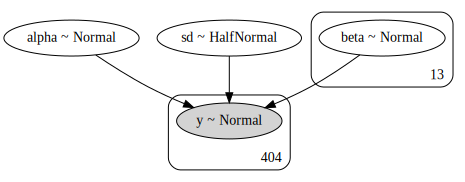

In [42]:
pm.model_to_graphviz(model_2)

In [43]:
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
alpha     26.021  4.810  16.423   34.584      0.090    0.063    2883.0   
beta[0]   -0.113  0.038  -0.181   -0.040      0.001    0.000    5558.0   
beta[1]    0.048  0.016   0.019    0.078      0.000    0.000    4723.0   
beta[2]   -0.009  0.070  -0.139    0.123      0.001    0.001    5157.0   
beta[3]    3.115  1.009   1.268    5.055      0.013    0.009    6503.0   
beta[4]  -11.357  3.713 -18.107   -4.156      0.057    0.040    4267.0   
beta[5]    4.372  0.437   3.589    5.235      0.007    0.005    3503.0   
beta[6]   -0.014  0.014  -0.040    0.014      0.000    0.000    5335.0   
beta[7]   -1.395  0.222  -1.795   -0.966      0.003    0.002    4342.0   
beta[8]    0.259  0.074   0.118    0.393      0.001    0.001    3579.0   
beta[9]   -0.013  0.004  -0.021   -0.005      0.000    0.000    3572.0   
beta[10]  -0.762  0.140  -1.030   -0.512      0.002    0.002    3762.0   
beta[11]   0.010  0.003   0.004    0.015      0.000    0.000    5161.0   
beta[12]  -0.435  0.056  -0.540   -0.331      0.001    0.001    3995.0   
sd         4.714  0.173   4.387    5.032      0.002    0.002    5685.0   

          ess_sd  ess_bulk  ess_tail  r_hat  
alpha     2883.0    2887.0    3137.0    1.0  
beta[0]   5558.0    5567.0    4406.0    1.0  
beta[1]   4611.0    4719.0    4115.0    1.0  
beta[2]   3449.0    5171.0    3714.0    1.0  
beta[3]   6391.0    6503.0    4614.0    1.0  
beta[4]   4229.0    4305.0    4167.0    1.0  
beta[5]   3456.0    3501.0    3551.0    1.0  
beta[6]   4240.0    5322.0    4433.0    1.0  
beta[7]   4282.0    4356.0    4500.0    1.0  
beta[8]   3573.0    3578.0    3888.0    1.0  
beta[9]   3450.0    3578.0    3900.0    1.0  
beta[10]  3735.0    3771.0    4024.0    1.0  
beta[11]  5101.0    5159.0    4450.0    1.0  
beta[12]  3989.0    4012.0    4406.0    1.0  
sd        5662.0    5722.0    4339.0    1.0

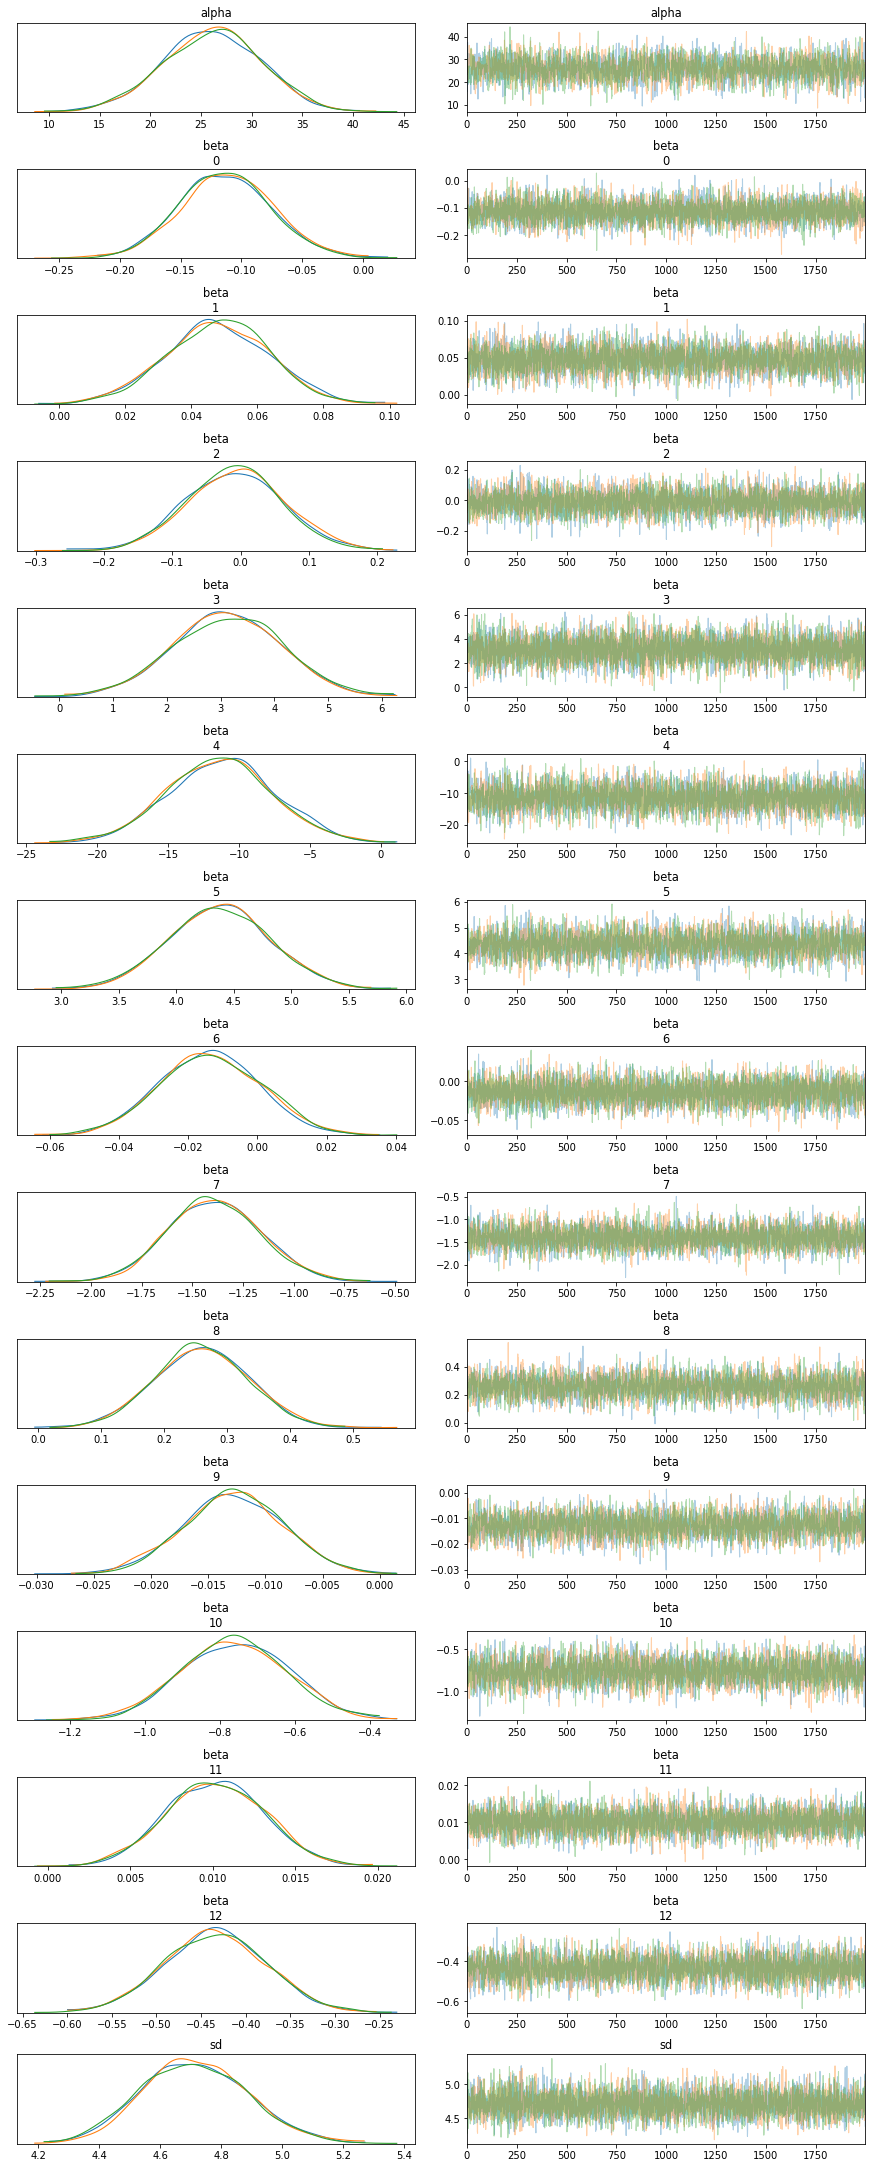

In [44]:
az.plot_trace(trace);

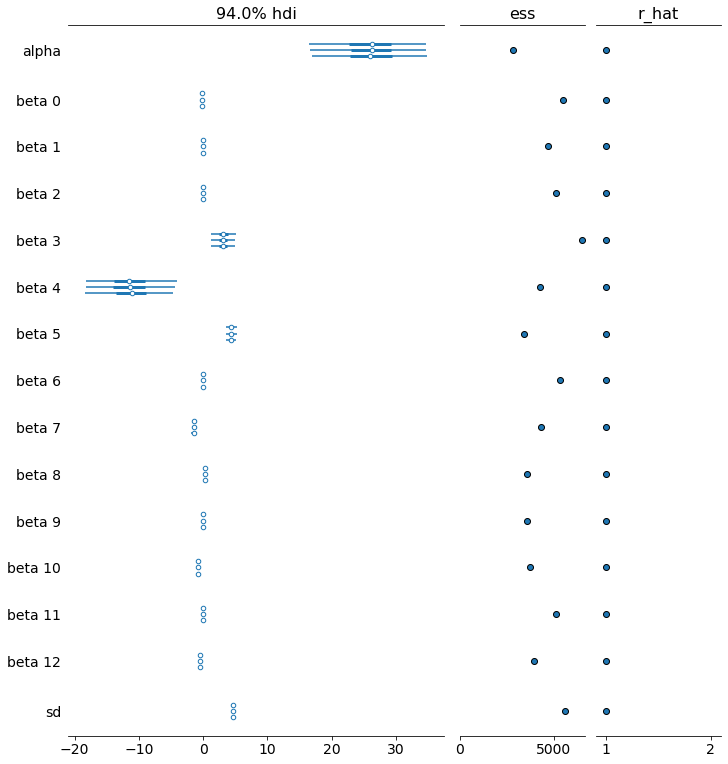

In [45]:
az.plot_forest(trace, r_hat=True, ess=True);

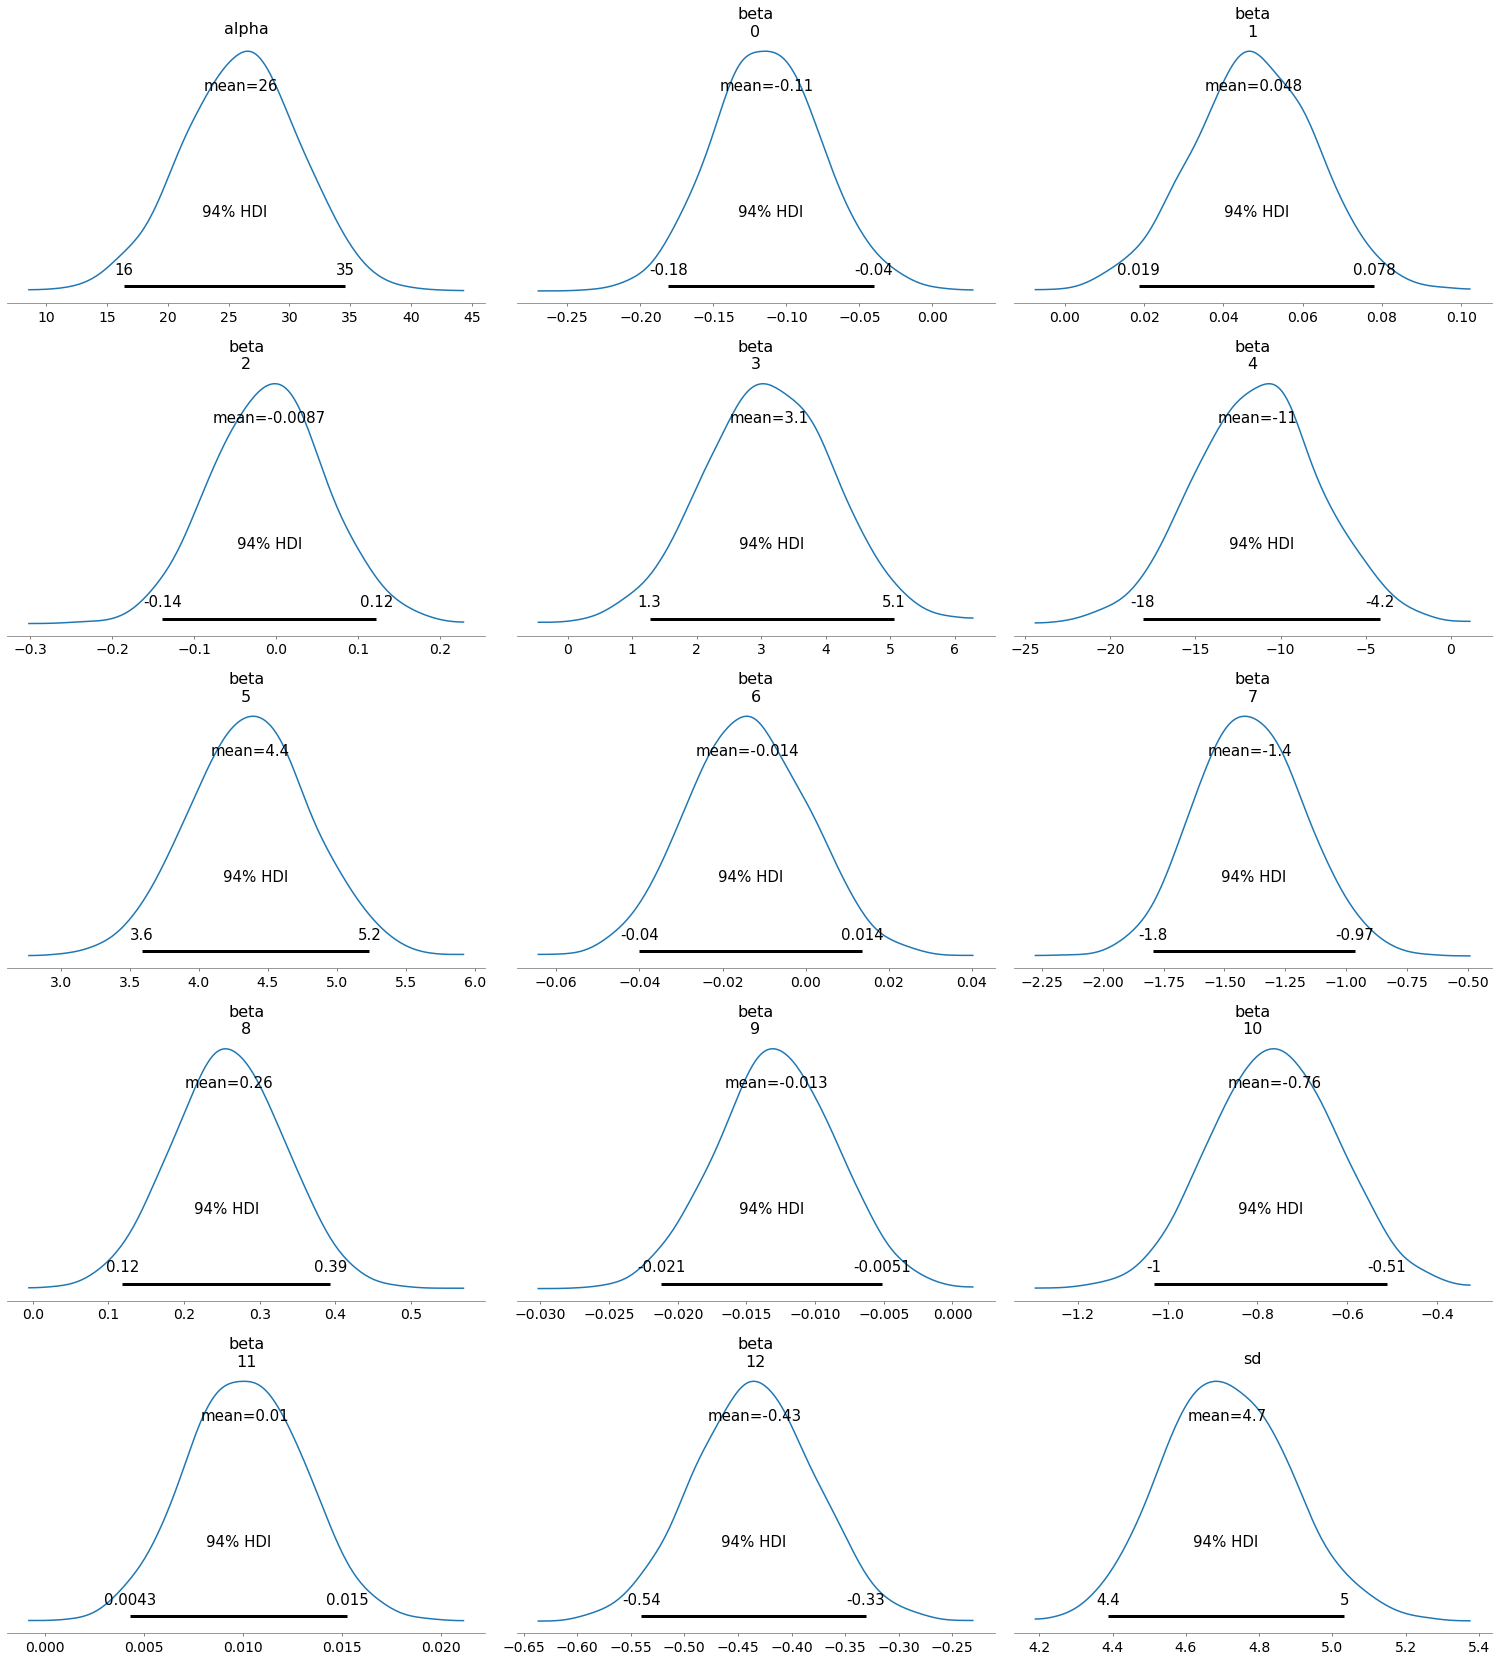

In [46]:
az.plot_posterior(trace);

/opt/anaconda3/envs/base_custom/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/pairplot.py:216: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  UserWarning,


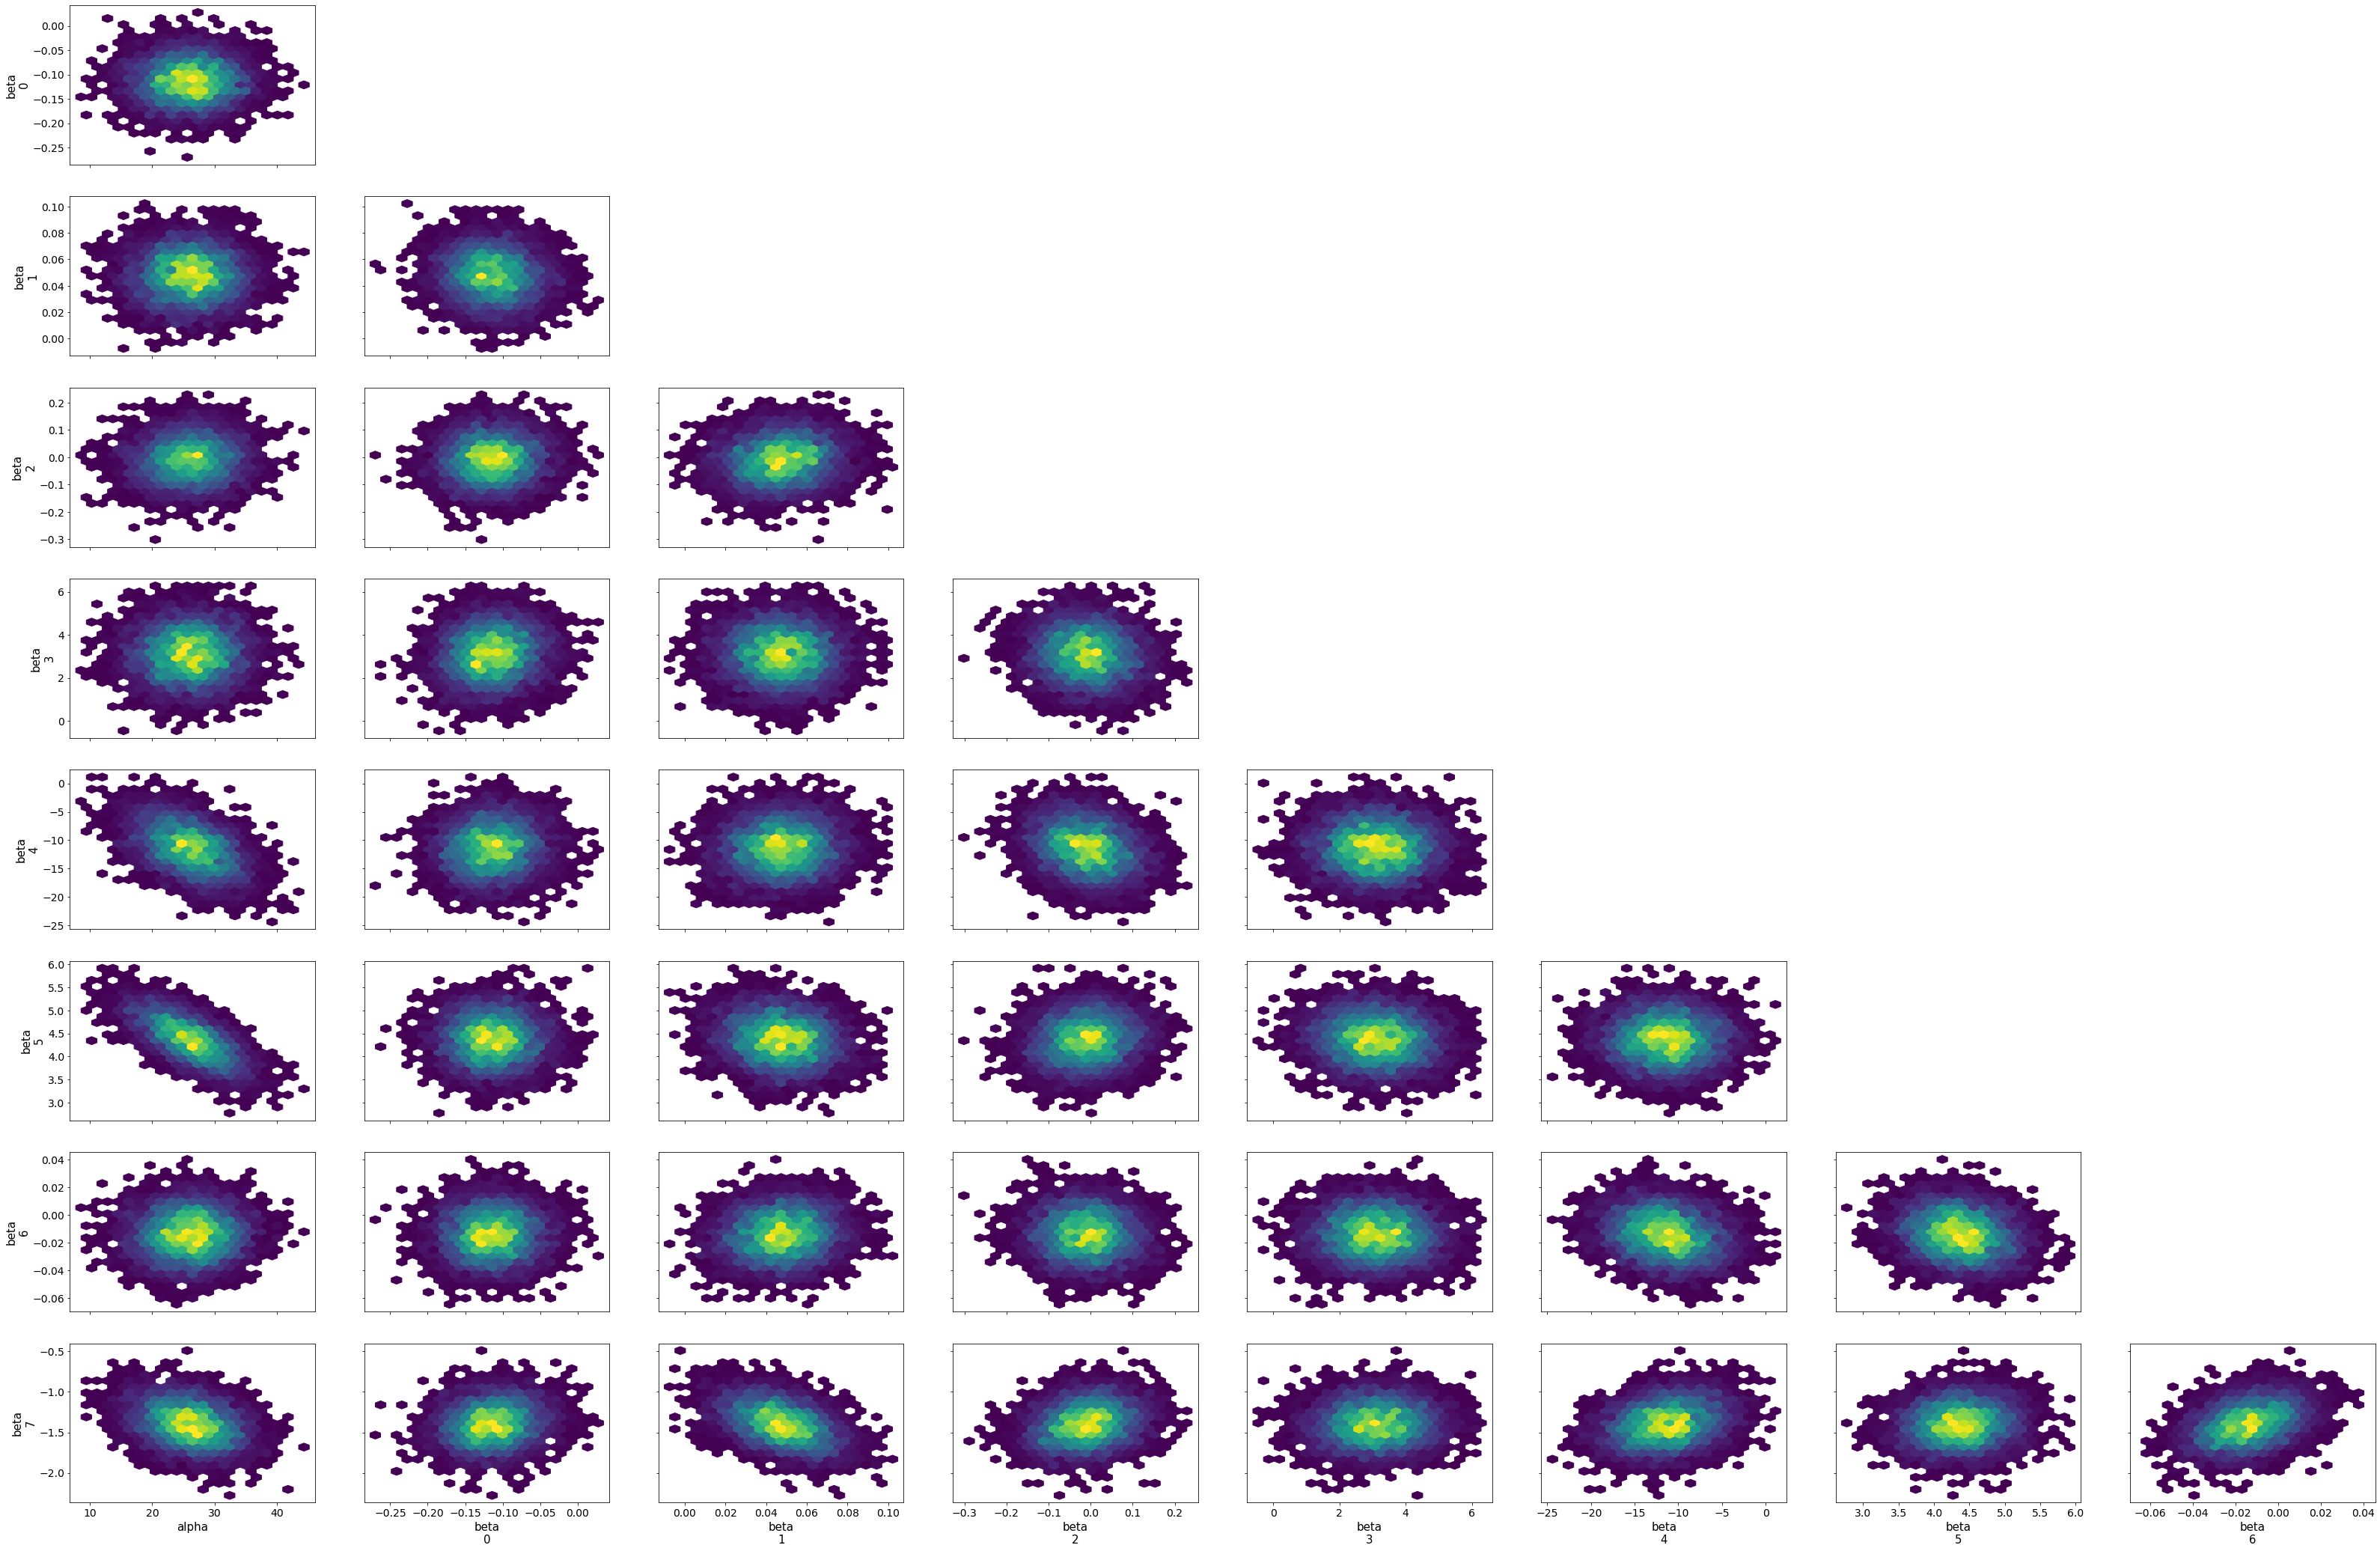

In [47]:
az.plot_pair(trace, kind='hexbin');

In [48]:
X_shared.set_value(X_test)

In [49]:
predictions = pm.sample_posterior_predictive(trace, model=model_2)

100%|██████████| 6000/6000 [01:11<00:00, 83.80it/s] 


In [50]:
predictions_posterior = predictions['y'].T

Text(0.5, 1.0, 'posterior distribution of first 10 predictions')

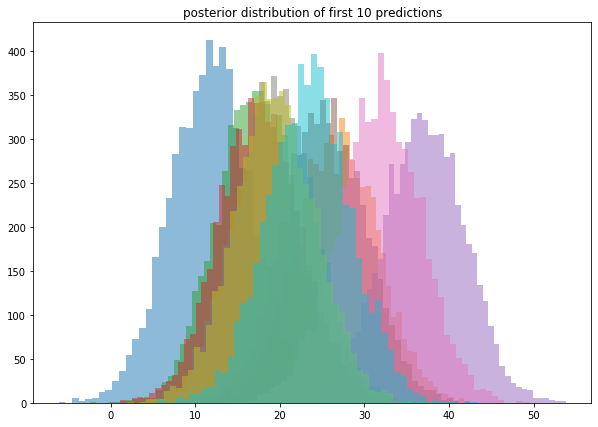

In [51]:
plt.figure(figsize=[10,7])
for x in range(0,10):
    plt.hist(predictions_posterior[x], bins=50, alpha=0.5)
plt.title("posterior distribution of first 10 predictions")

In [52]:
def prediction_intervals(predictions_posterior, percentile):
    predictions = np.array([np.mean(each) for each in predictions_posterior])
    err_down = np.array([np.percentile(each, (100 - percentile) / 2) for each in predictions_posterior])
    err_up = np.array([np.percentile(each, 100 - (100 - percentile) / 2) for each in predictions_posterior])
    return np.transpose(np.array([predictions, err_down, err_up]))

In [53]:
prediction_ints = prediction_intervals(predictions_posterior, percentile=95)

In [54]:
prediction_ints_df = pd.DataFrame(prediction_ints)
prediction_ints_df.columns = ["PREDICTION","LOWER","UPPER"]

In [55]:
actual_prediction_df = pd.DataFrame({'ACTUAL' : y_test}).reset_index(drop=True)

In [56]:
results_df = pd.concat([actual_prediction_df, prediction_ints_df], axis=1)

In [57]:
results_df

ACTUAL  PREDICTION      LOWER      UPPER
0      16.5   11.932259   2.476171  21.464635
1      24.8   26.816875  17.589459  36.232459
2      17.4   17.253732   8.297990  26.563895
3      19.3   17.635165   8.317358  27.196561
4      37.6   37.117394  27.850719  46.103338
..      ...         ...        ...        ...
97     50.0   21.292290  11.725783  30.824707
98     11.8    9.981247   0.428628  19.518303
99     19.5   20.627163  11.148153  29.811570
100     8.7    9.311460  -0.151320  18.676275
101    23.3   26.690957  17.120389  36.153262

[102 rows x 4 columns]

In [58]:
r2_score(results_df.ACTUAL, results_df.PREDICTION)

0.7231057875583715

In [59]:
results_df_sorted = results_df.sort_values(by='ACTUAL').reset_index(drop=True)

(0, 60)

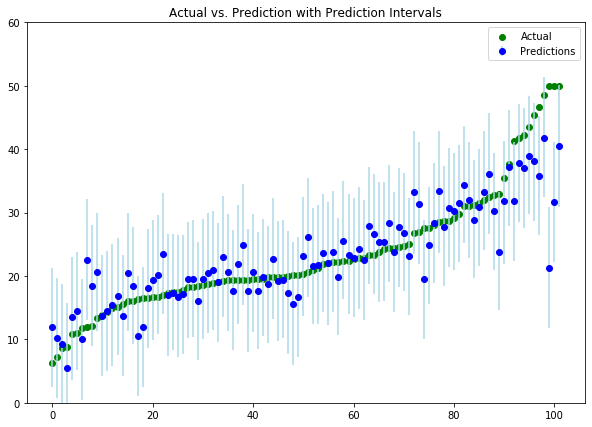

In [60]:
plt.figure(figsize=[10,7])
plt.scatter(results_df_sorted.index,
            results_df_sorted.ACTUAL,
            color='green')
plt.errorbar(results_df_sorted.index,
             results_df_sorted.PREDICTION,
             yerr=[results_df_sorted.PREDICTION - results_df_sorted.LOWER, 
                   results_df_sorted.UPPER - results_df_sorted.PREDICTION],
             ecolor='lightblue', 
             fmt='bo',
             elinewidth=0)
plt.title("Actual vs. Prediction with Prediction Intervals")
plt.legend(['Actual','Predictions'])
plt.ylim([0,60])

In [61]:
correct = 0
for each_row in results_df.itertuples():
    if each_row.LOWER <= each_row.ACTUAL <= each_row.UPPER:
        correct += 1
print(correct/results_df.shape[0])

0.9509803921568627


# hierarchical modeling and variational inference

In [62]:
from sklearn.datasets import load_boston

In [63]:
boston = load_boston()
features = boston["data"]
feature_names = boston["feature_names"]
labels = boston["target"]

In [64]:
df = pd.DataFrame(features)
df.columns = feature_names 
df["LABEL"] = labels

In [65]:
X = df.drop(columns=["LABEL"])
y = df["LABEL"]

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [67]:
X_shared = theano.shared(np.array(X_train))
y_shared = theano.shared(np.array(y_train))

In [68]:
with pm.Model() as model_3: 
    # hyperpriors  
    beta_mu = pm.Normal('beta_mu', 1, sigma=10, shape=X_train.shape[1])
    beta_sigma = pm.Uniform('beta_sigma', lower=1, upper=10, shape=X_train.shape[1])
    # priors 
    alpha = pm.Normal('alpha', 0, sigma=10)
    beta = pm.Normal('beta', beta_mu, sigma=beta_sigma, shape=X_train.shape[1])
    sd = pm.HalfNormal('sd', sigma=10)
    # likelihood 
    y = alpha + theano.tensor.dot(X_shared, beta.T)
    pm.Normal('y', mu=y, sigma=sd, observed=y_shared)
    # inference 
    mean_field = pm.fit(n=50000, method='advi')

Average Loss = 1,424.7: 100%|██████████| 50000/50000 [00:22<00:00, 2220.81it/s]  
Finished [100%]: Average Loss = 1,424.3


In [69]:
model_3.model

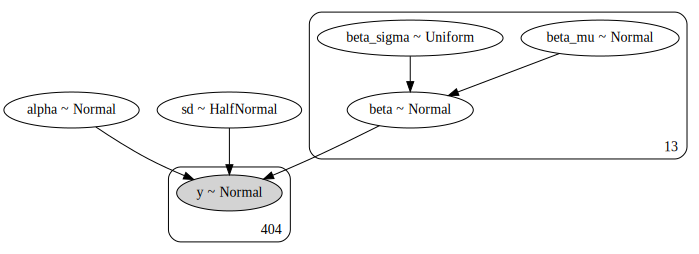

In [70]:
pm.model_to_graphviz(model_3)

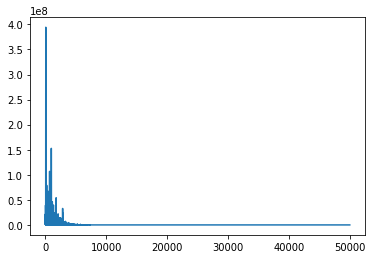

In [71]:
plt.plot(mean_field.hist);

In [72]:
trace = mean_field.sample(5000)

In [74]:
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
beta_mu[0]      0.075  3.860  -7.413    7.028      0.053    0.038    5213.0   
beta_mu[1]      0.224  3.816  -6.812    7.228      0.054    0.039    4928.0   
beta_mu[2]      0.070  3.800  -6.968    7.181      0.055    0.039    4793.0   
beta_mu[3]      1.522  4.376  -6.747    9.485      0.062    0.044    4996.0   
beta_mu[4]      0.437  4.014  -7.434    7.558      0.062    0.044    4205.0   
beta_mu[5]      0.619  3.915  -6.679    7.806      0.054    0.040    5264.0   
beta_mu[6]      0.114  3.756  -6.771    7.308      0.053    0.038    4944.0   
beta_mu[7]      0.226  3.913  -7.503    7.221      0.055    0.039    5019.0   
beta_mu[8]      0.172  3.876  -6.873    7.734      0.054    0.039    5077.0   
beta_mu[9]      0.099  3.824  -7.334    6.897      0.055    0.039    4806.0   
beta_mu[10]     0.245  3.807  -6.976    7.119      0.053    0.038    5178.0   
beta_mu[11]     0.323  3.788  -6.940    7.435      0.053    0.038    5138.0   
beta_mu[12]    -0.070  3.774  -7.170    6.937      0.055    0.039    4770.0   
alpha          -0.271  0.685  -1.530    1.059      0.010    0.007    4868.0   
beta[0]        -0.116  0.058  -0.224   -0.006      0.001    0.001    4857.0   
beta[1]         0.088  0.020   0.050    0.124      0.000    0.000    4763.0   
beta[2]        -0.082  0.059  -0.194    0.026      0.001    0.001    5093.0   
beta[3]         3.519  1.918   0.106    7.353      0.030    0.021    4168.0   
beta[4]         0.550  1.033  -1.350    2.515      0.015    0.011    4882.0   
beta[5]         1.226  0.127   0.982    1.456      0.002    0.001    4864.0   
beta[6]         0.096  0.011   0.077    0.118      0.000    0.000    5242.0   
beta[7]         0.056  0.159  -0.226    0.374      0.002    0.002    4622.0   
beta[8]         0.054  0.056  -0.055    0.155      0.001    0.001    4612.0   
beta[9]         0.001  0.002  -0.003    0.004      0.000    0.000    5005.0   
beta[10]        0.273  0.044   0.187    0.353      0.001    0.000    4998.0   
beta[11]        0.030  0.002   0.026    0.034      0.000    0.000    4883.0   
beta[12]       -0.663  0.054  -0.764   -0.560      0.001    0.001    4823.0   
beta_sigma[0]   5.433  2.446   1.309    9.297      0.035    0.025    4820.0   
beta_sigma[1]   5.354  2.449   1.337    9.311      0.034    0.024    5190.0   
beta_sigma[2]   5.285  2.445   1.243    9.216      0.035    0.025    4851.0   
beta_sigma[3]   5.763  2.395   1.709    9.580      0.035    0.025    4766.0   
beta_sigma[4]   5.552  2.376   1.687    9.545      0.033    0.024    5095.0   
beta_sigma[5]   5.322  2.420   1.367    9.267      0.035    0.025    4752.0   
beta_sigma[6]   5.353  2.432   1.303    9.293      0.034    0.024    5065.0   
beta_sigma[7]   5.318  2.452   1.274    9.220      0.035    0.025    4966.0   
beta_sigma[8]   5.350  2.446   1.274    9.260      0.035    0.025    4959.0   
beta_sigma[9]   5.347  2.447   1.444    9.387      0.035    0.025    4863.0   
beta_sigma[10]  5.364  2.439   1.405    9.377      0.035    0.025    4989.0   
beta_sigma[11]  5.397  2.489   1.339    9.374      0.035    0.025    5029.0   
beta_sigma[12]  5.393  2.435   1.342    9.304      0.035    0.025    4794.0   
sd              6.823  0.297   6.299    7.409      0.004    0.003    5006.0   

                ess_sd  ess_bulk  ess_tail  r_hat  
beta_mu[0]      5191.0    5212.0    4927.0    NaN  
beta_mu[1]      4834.0    4956.0    4830.0    NaN  
beta_mu[2]      4722.0    4797.0    4597.0    NaN  
beta_mu[3]      4996.0    4998.0    5026.0    NaN  
beta_mu[4]      4126.0    4205.0    4796.0    NaN  
beta_mu[5]      4770.0    5263.0    4868.0    NaN  
beta_mu[6]      4942.0    4938.0    4651.0    NaN  
beta_mu[7]      5019.0    5018.0    4996.0    NaN  
beta_mu[8]      4943.0    5074.0    4941.0    NaN  
beta_mu[9]      4806.0    4807.0    4684.0    NaN  
beta_mu[10]     5147.0    5178.0    4932.0    NaN  
beta_mu[11]     4938.0    5142.0    4757.0    NaN  
beta_mu[12]     4770.0

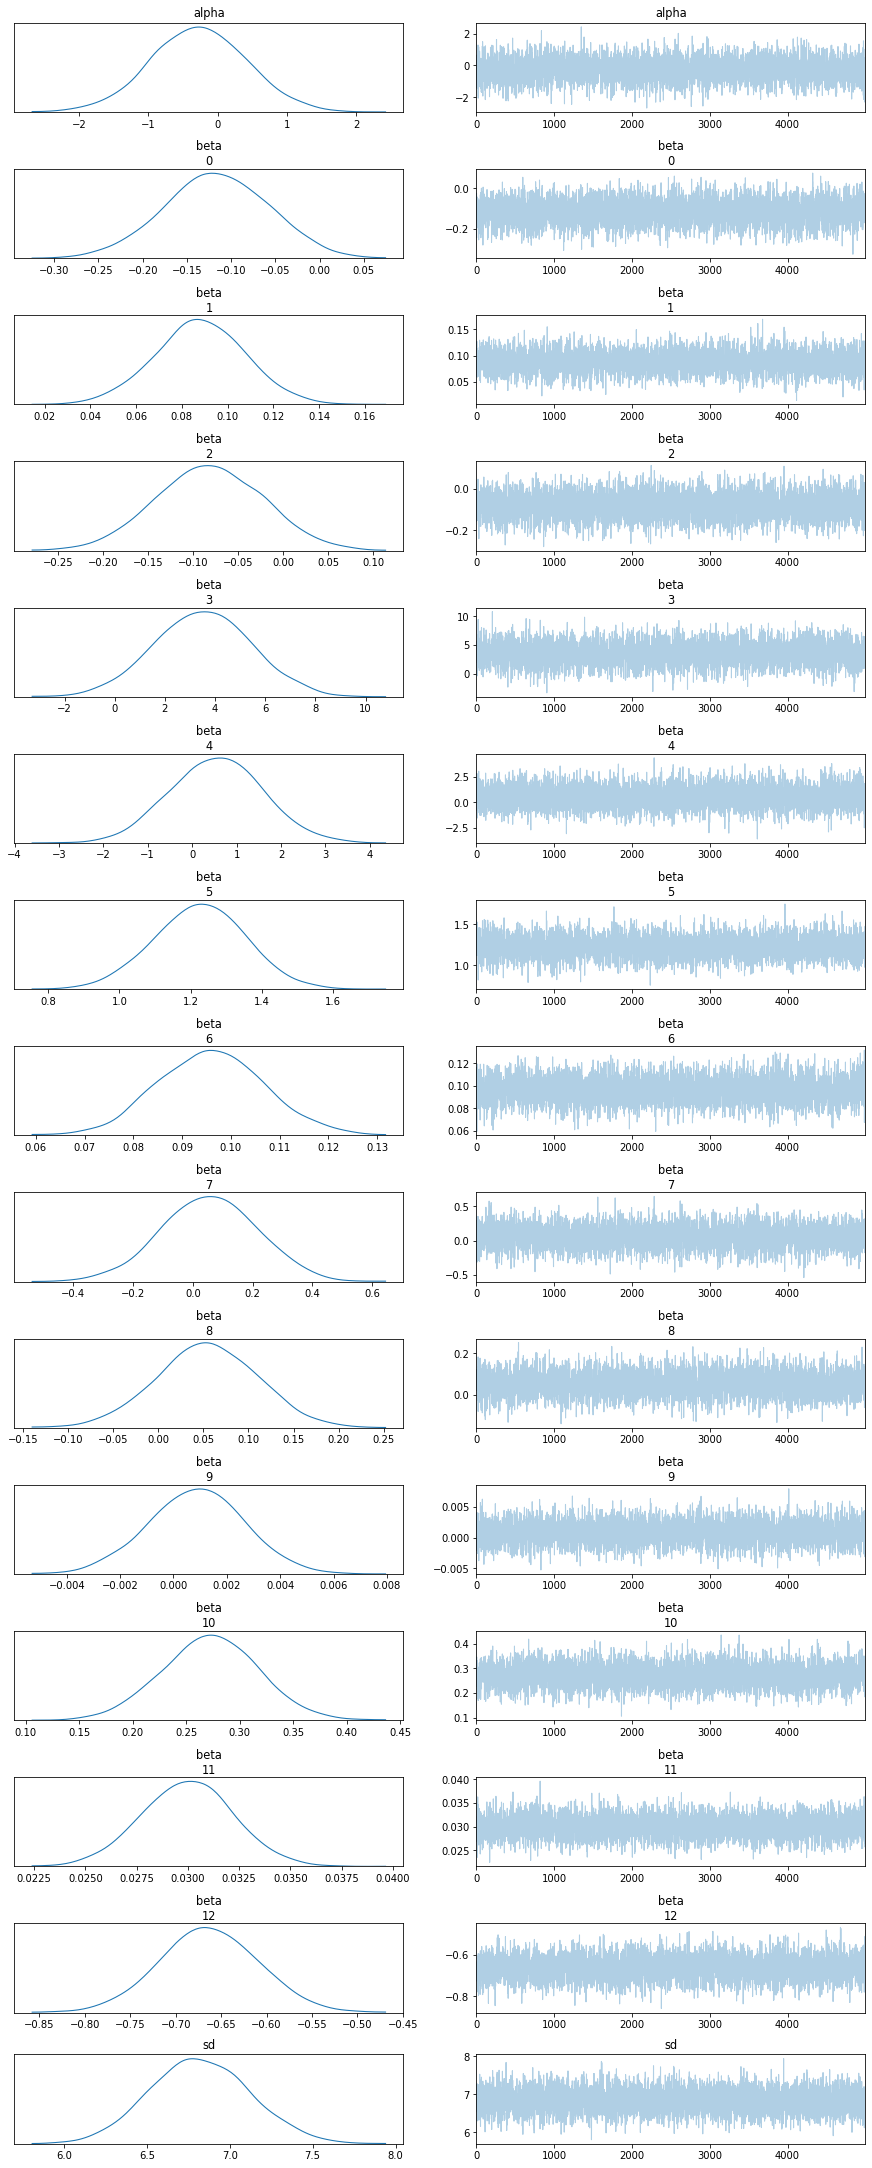

In [75]:
az.plot_trace(trace, var_names=['alpha','beta','sd']);

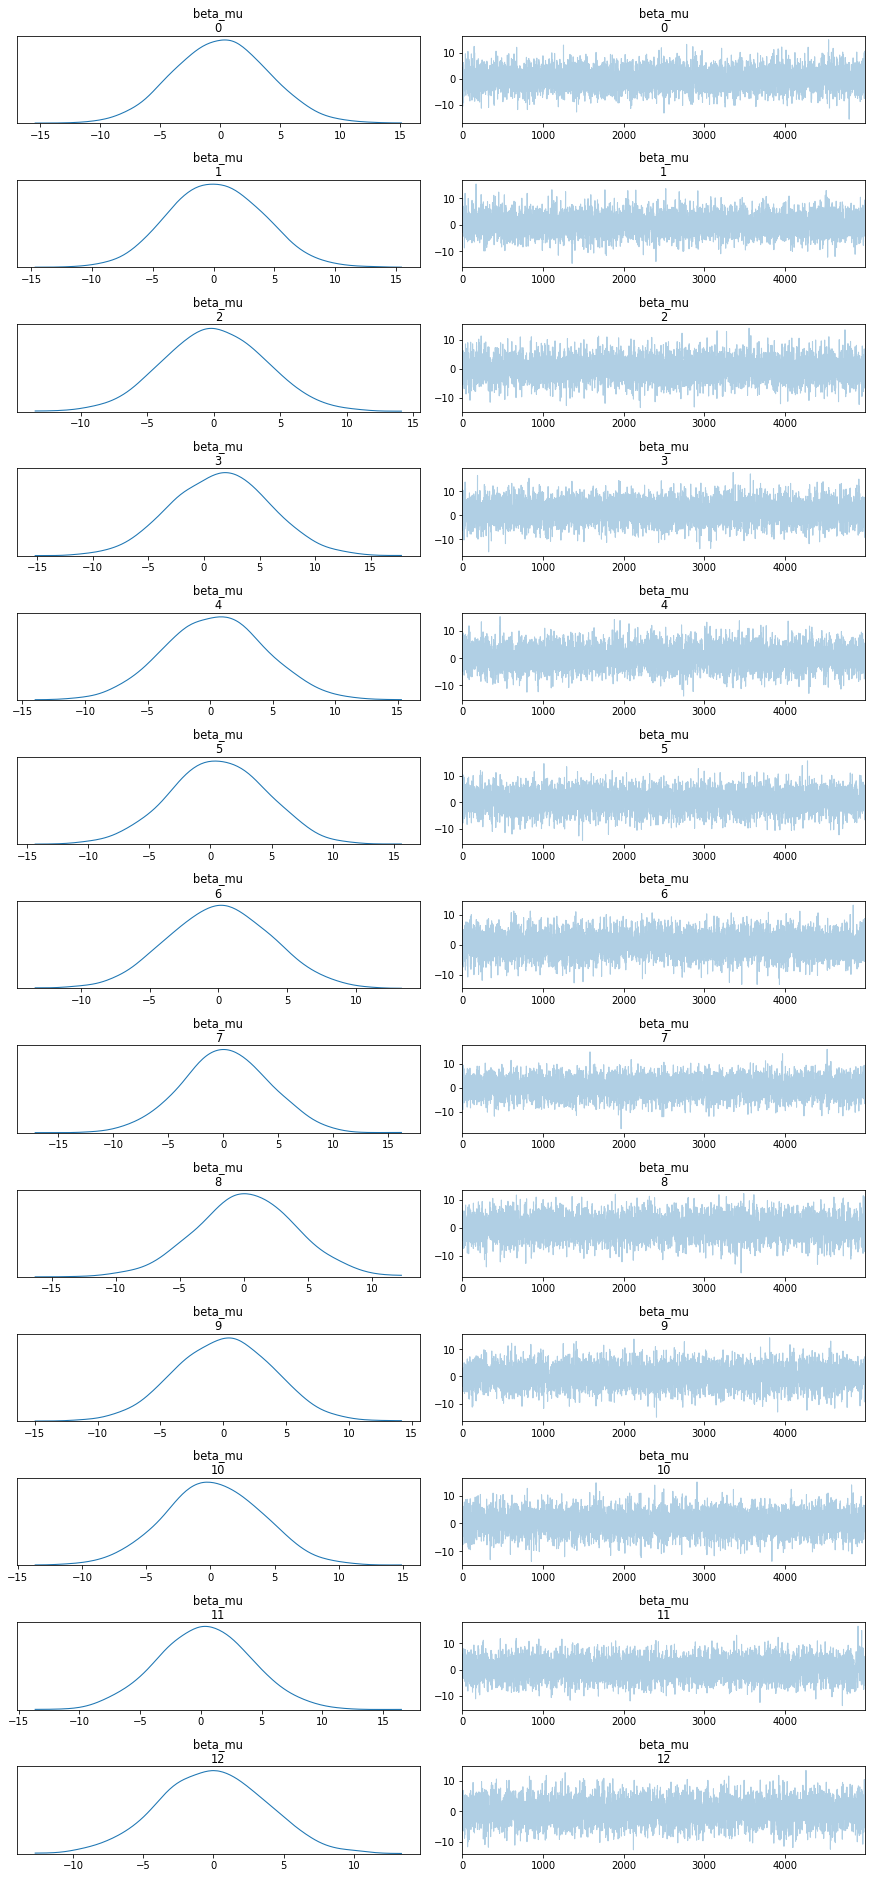

In [76]:
az.plot_trace(trace, var_names=['beta_mu']);

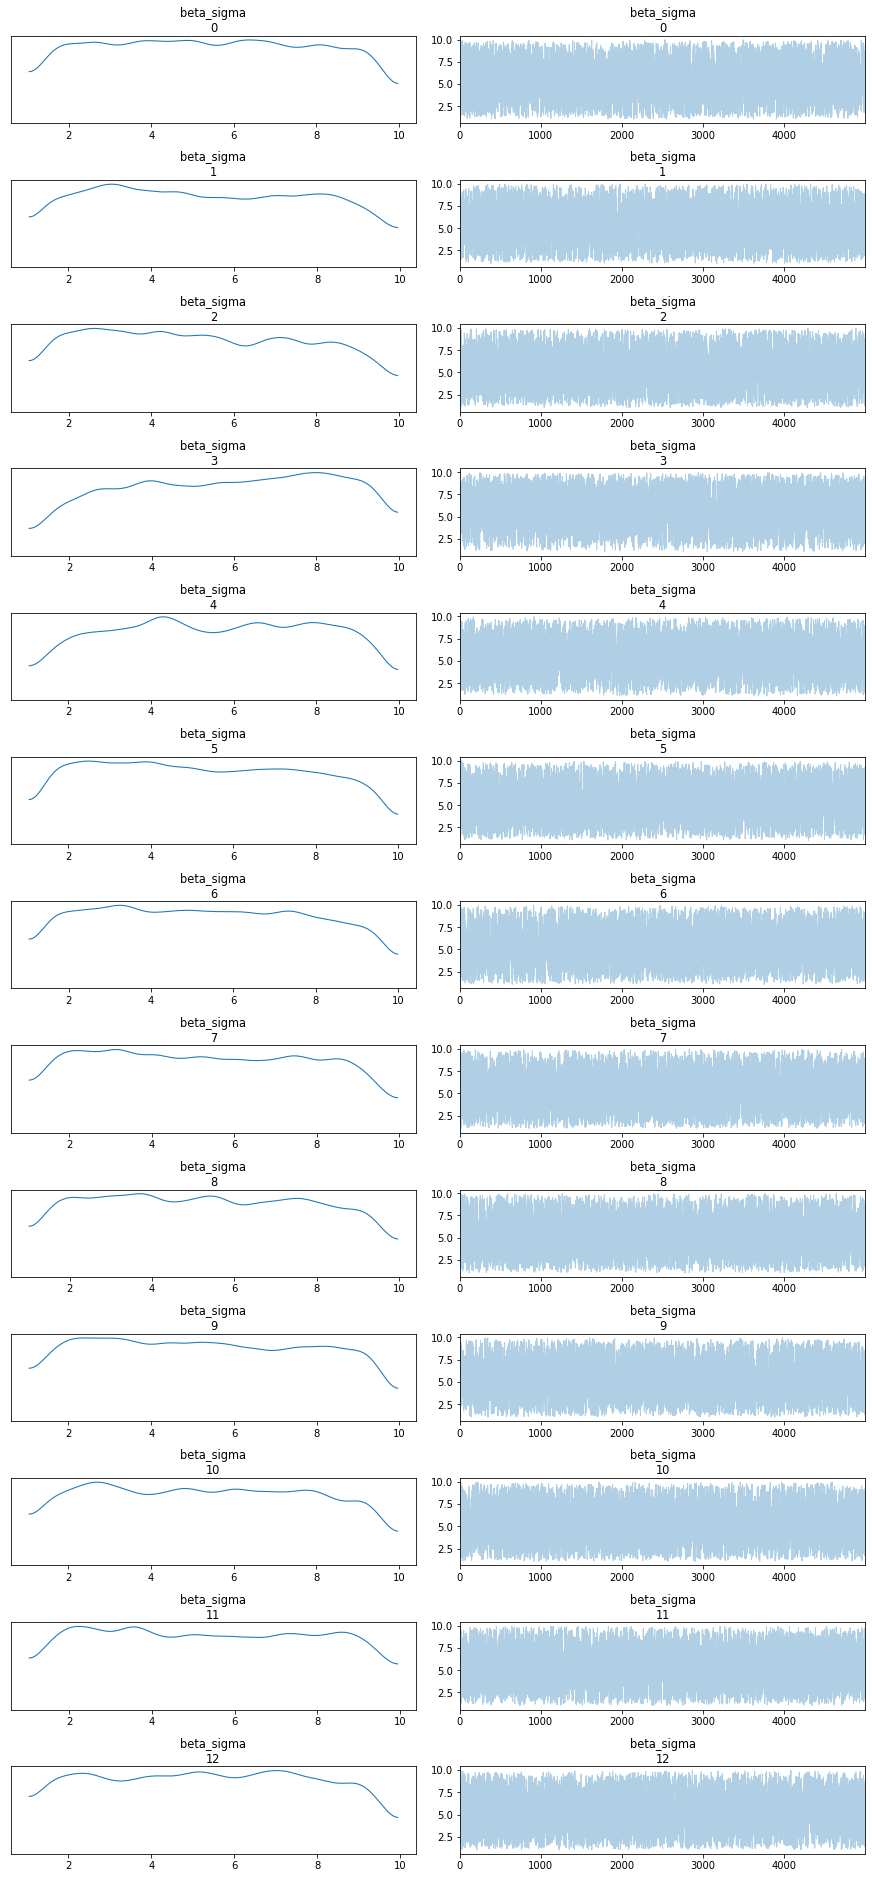

In [77]:
az.plot_trace(trace, var_names=['beta_sigma']);

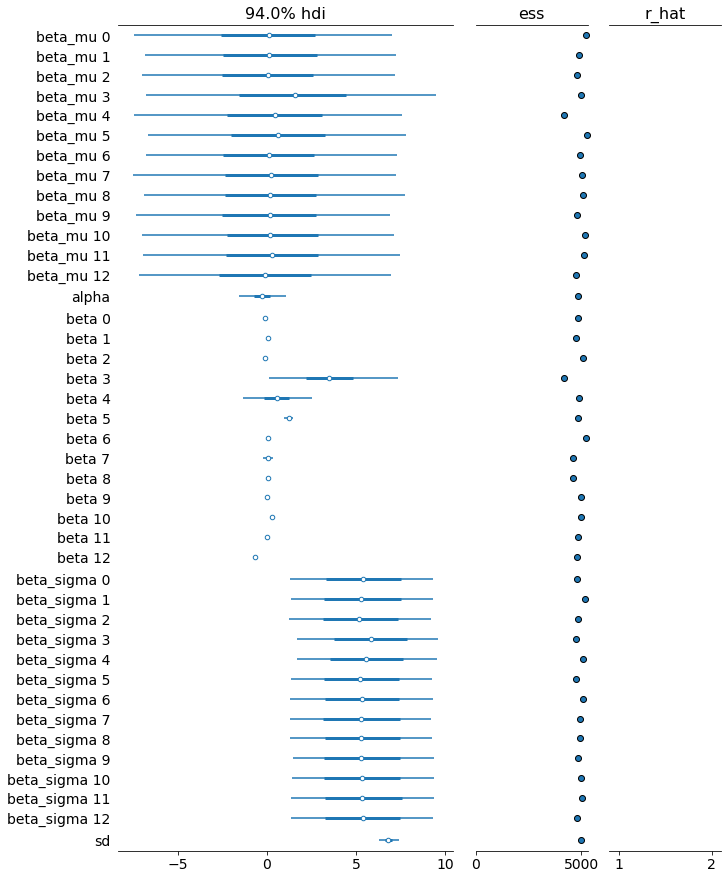

In [78]:
az.plot_forest(trace, r_hat=True, ess=True);

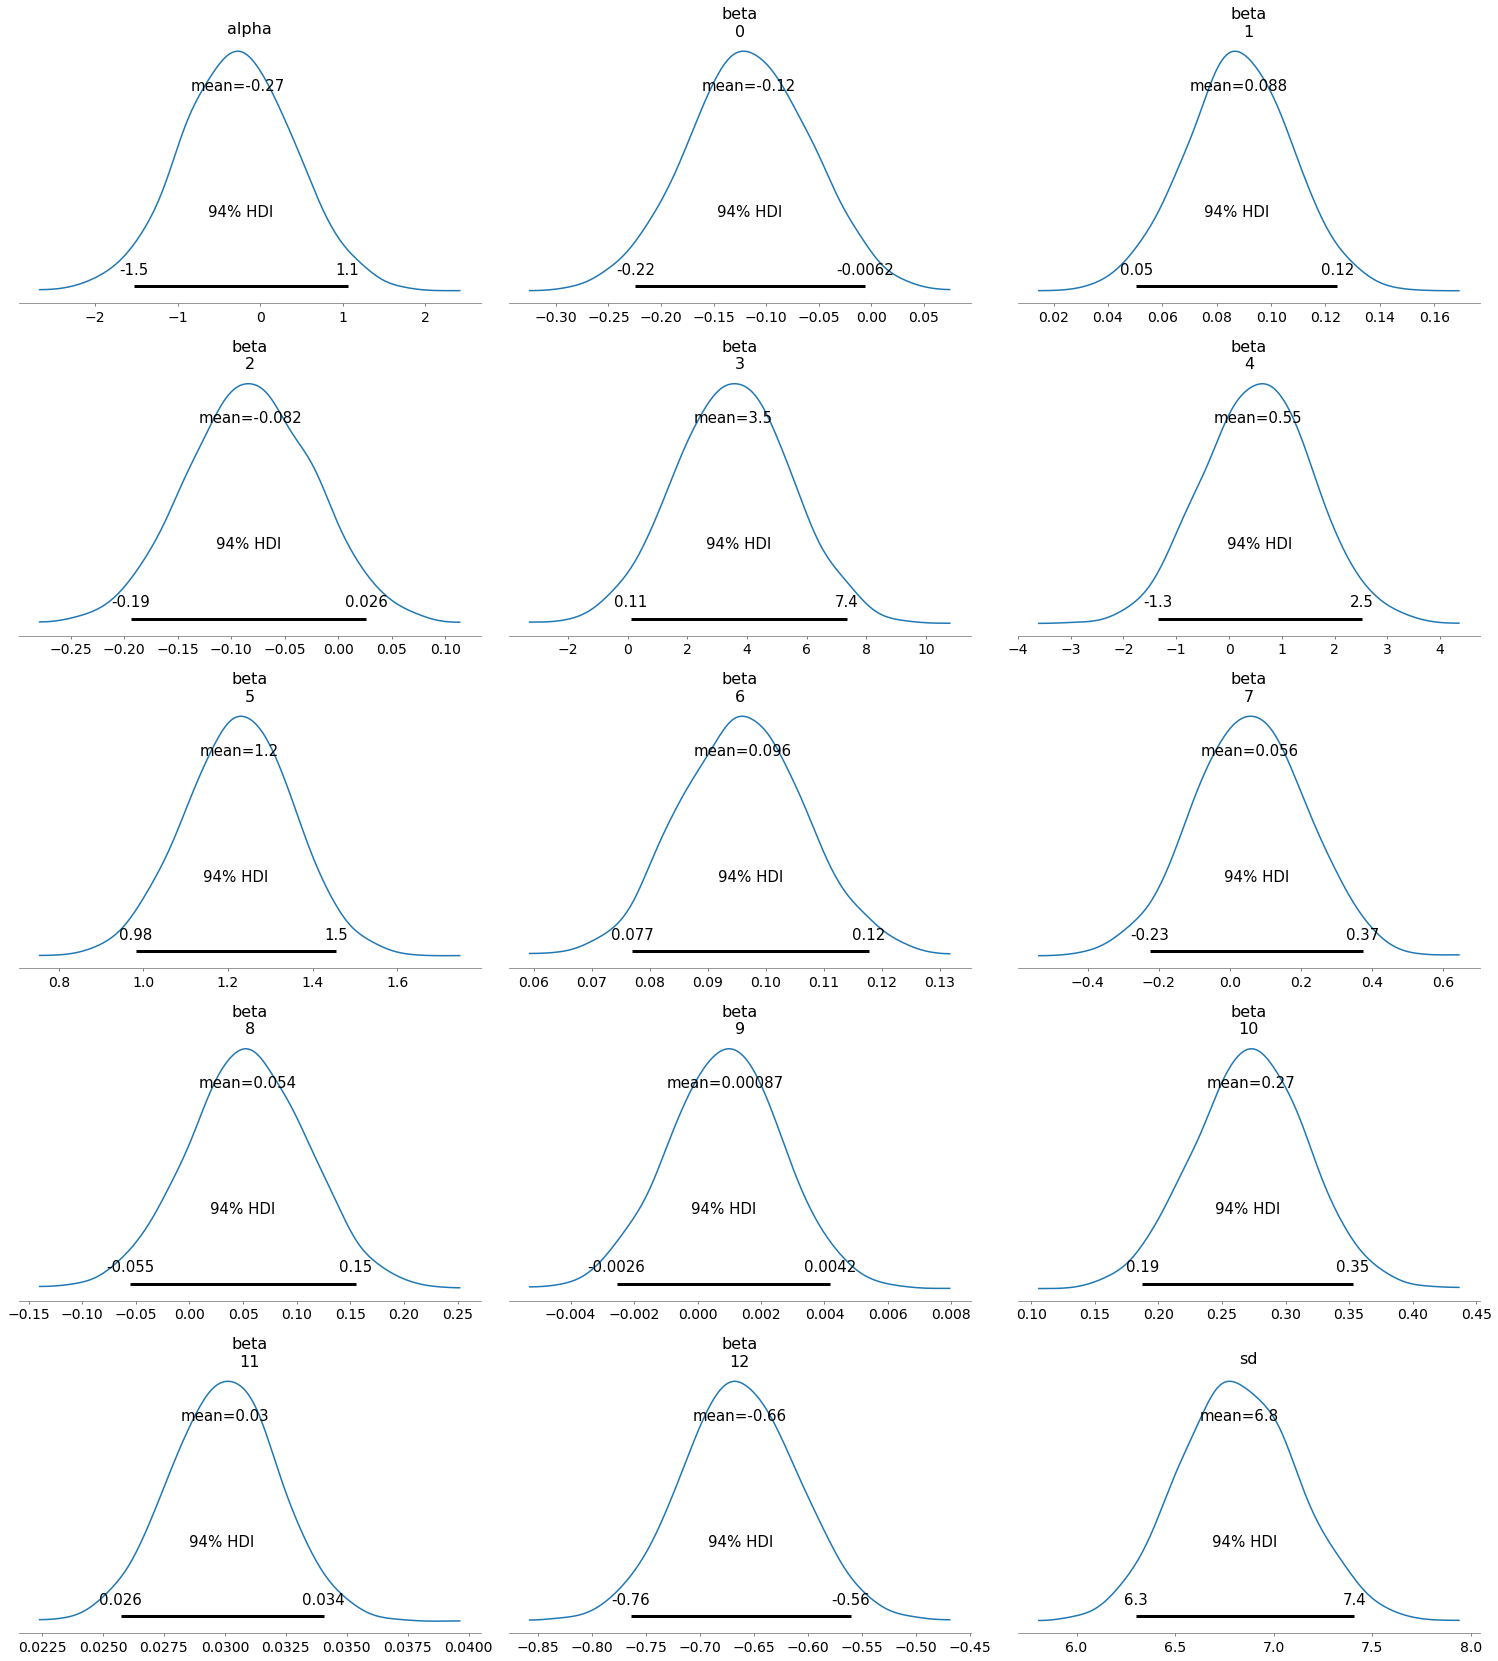

In [79]:
az.plot_posterior(trace, var_names=['alpha','beta','sd']);

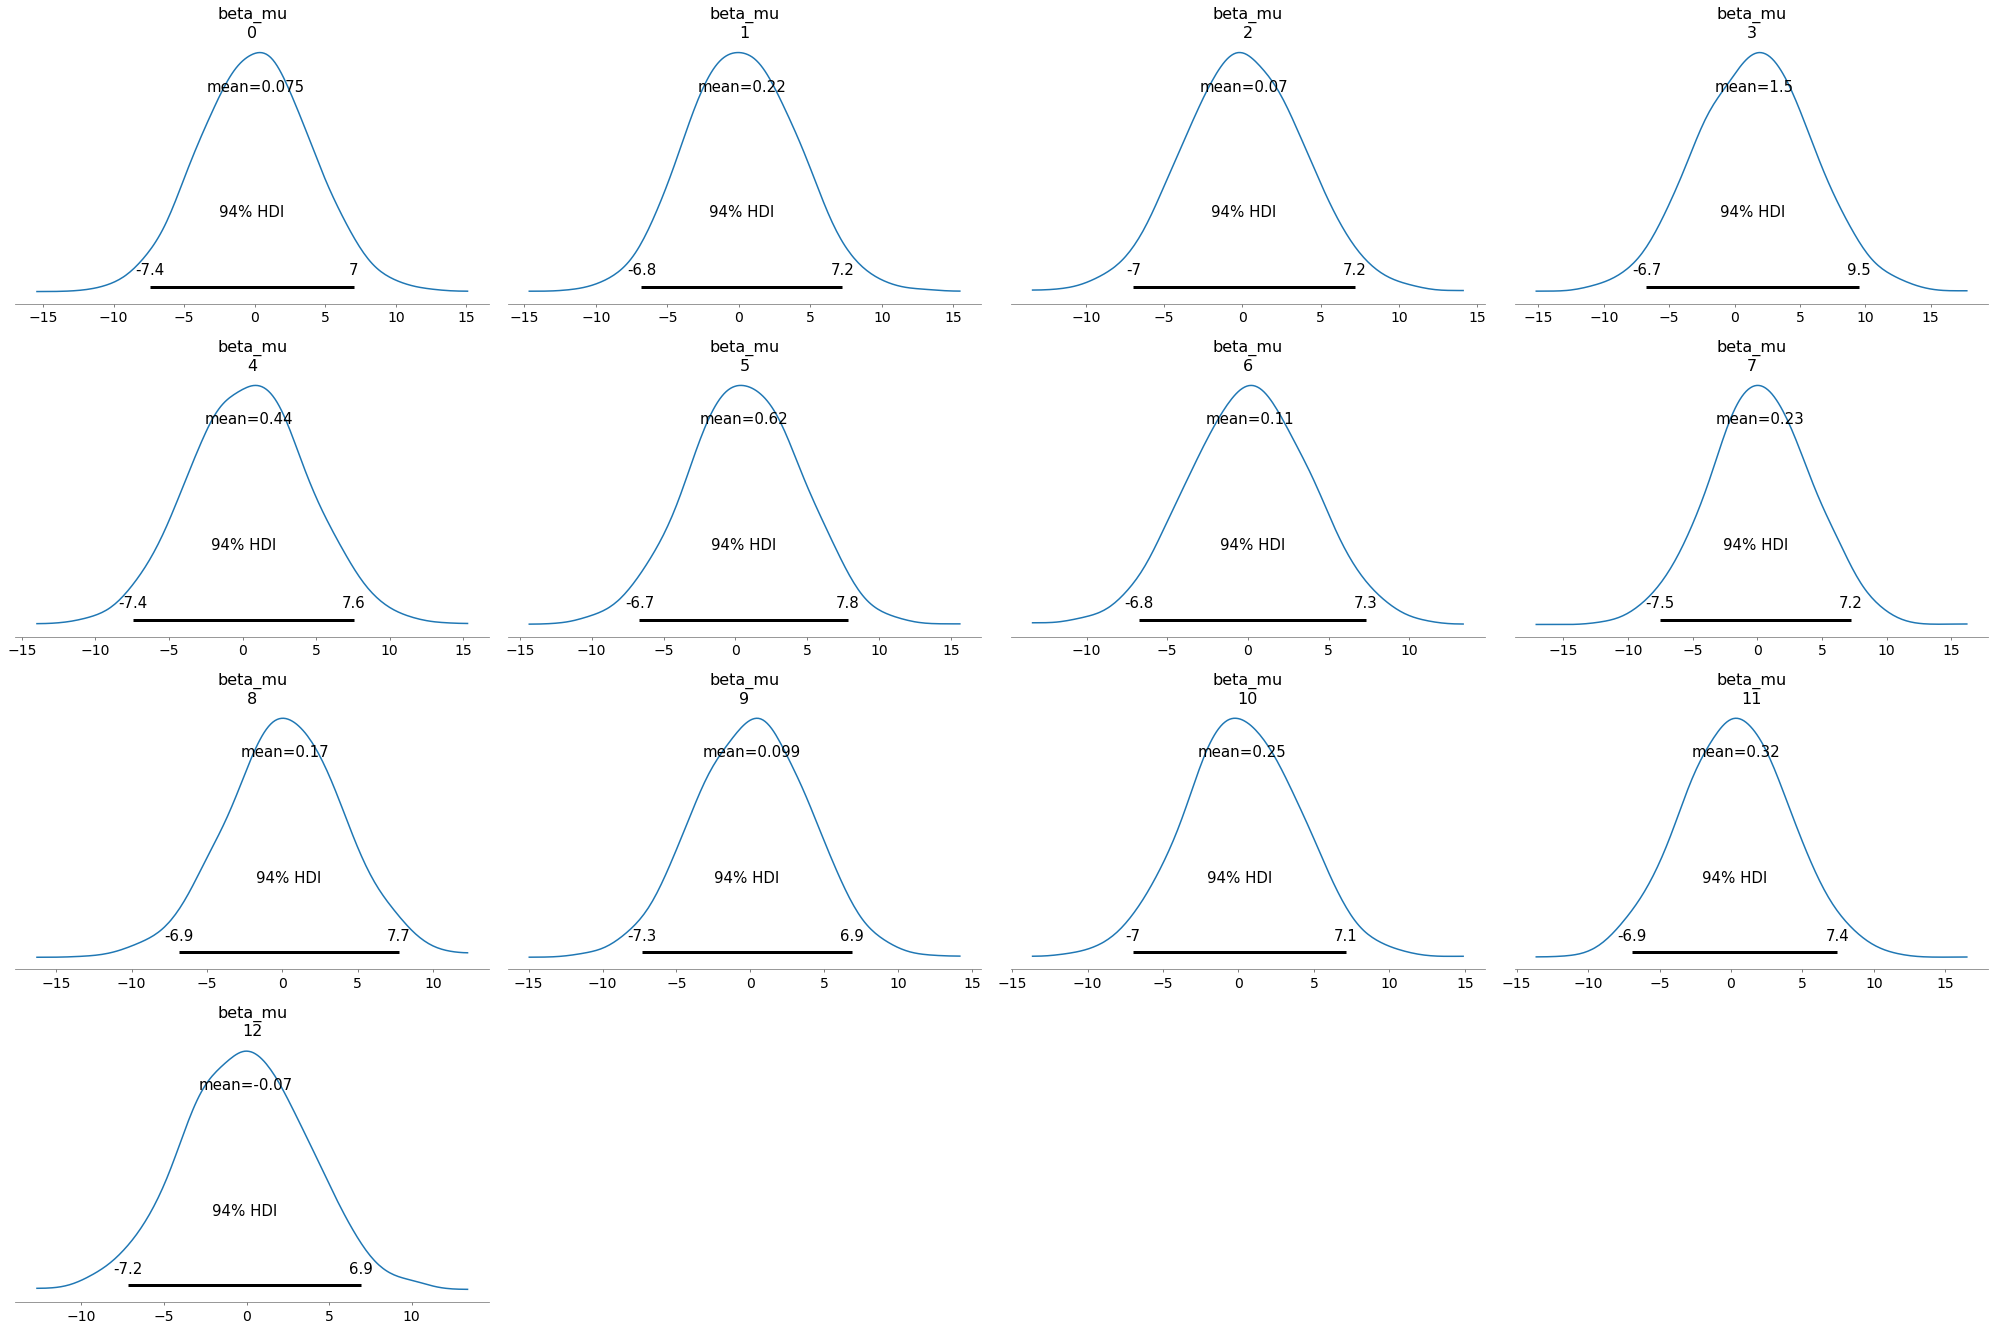

In [80]:
az.plot_posterior(trace, var_names=['beta_mu']);

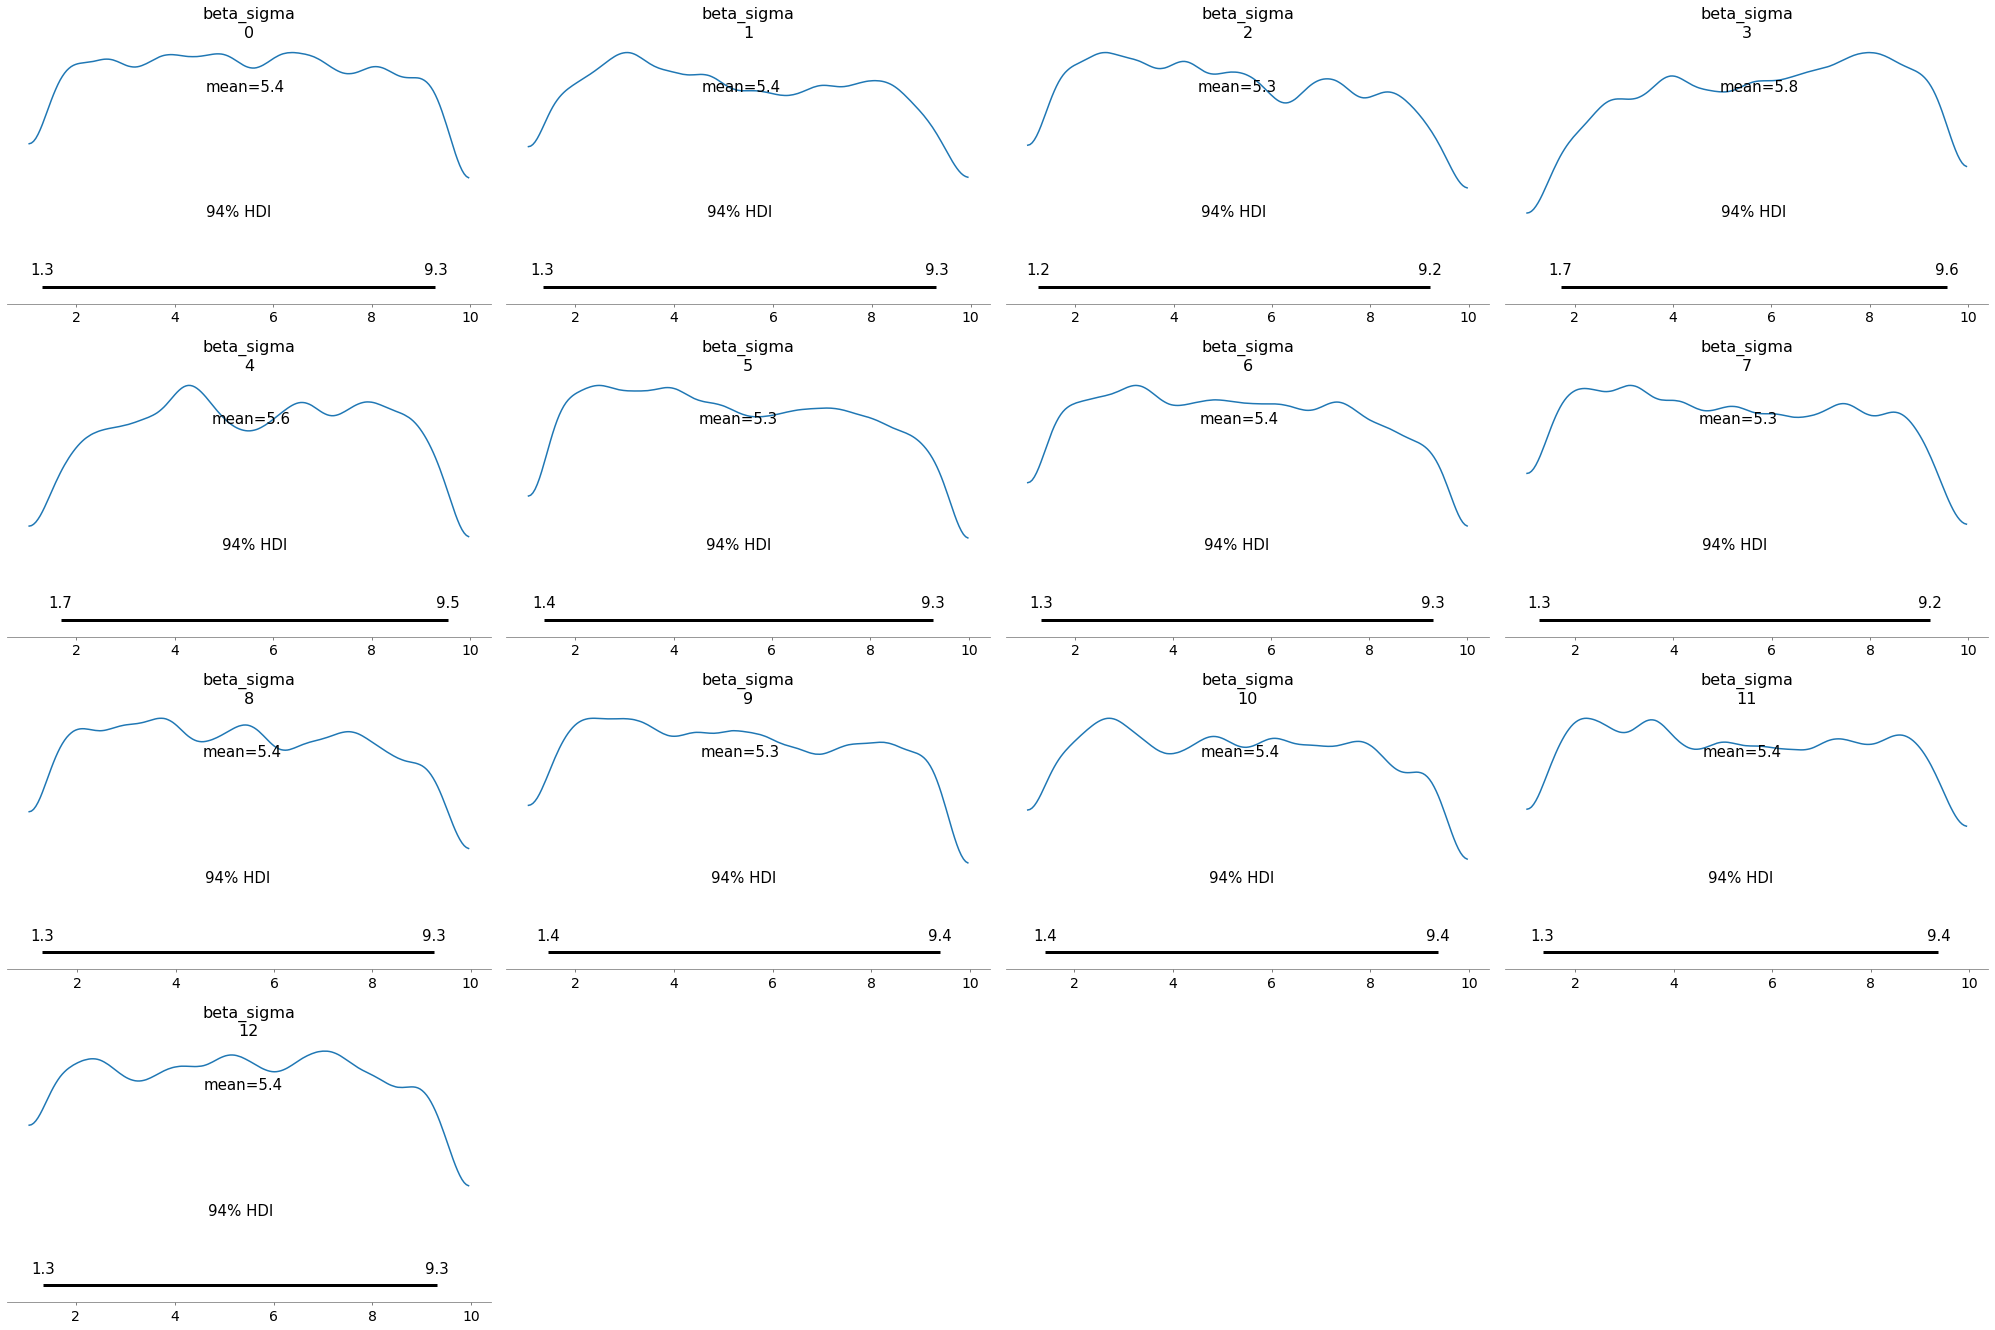

In [81]:
az.plot_posterior(trace, var_names=['beta_sigma']);

/opt/anaconda3/envs/base_custom/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/pairplot.py:216: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  UserWarning,


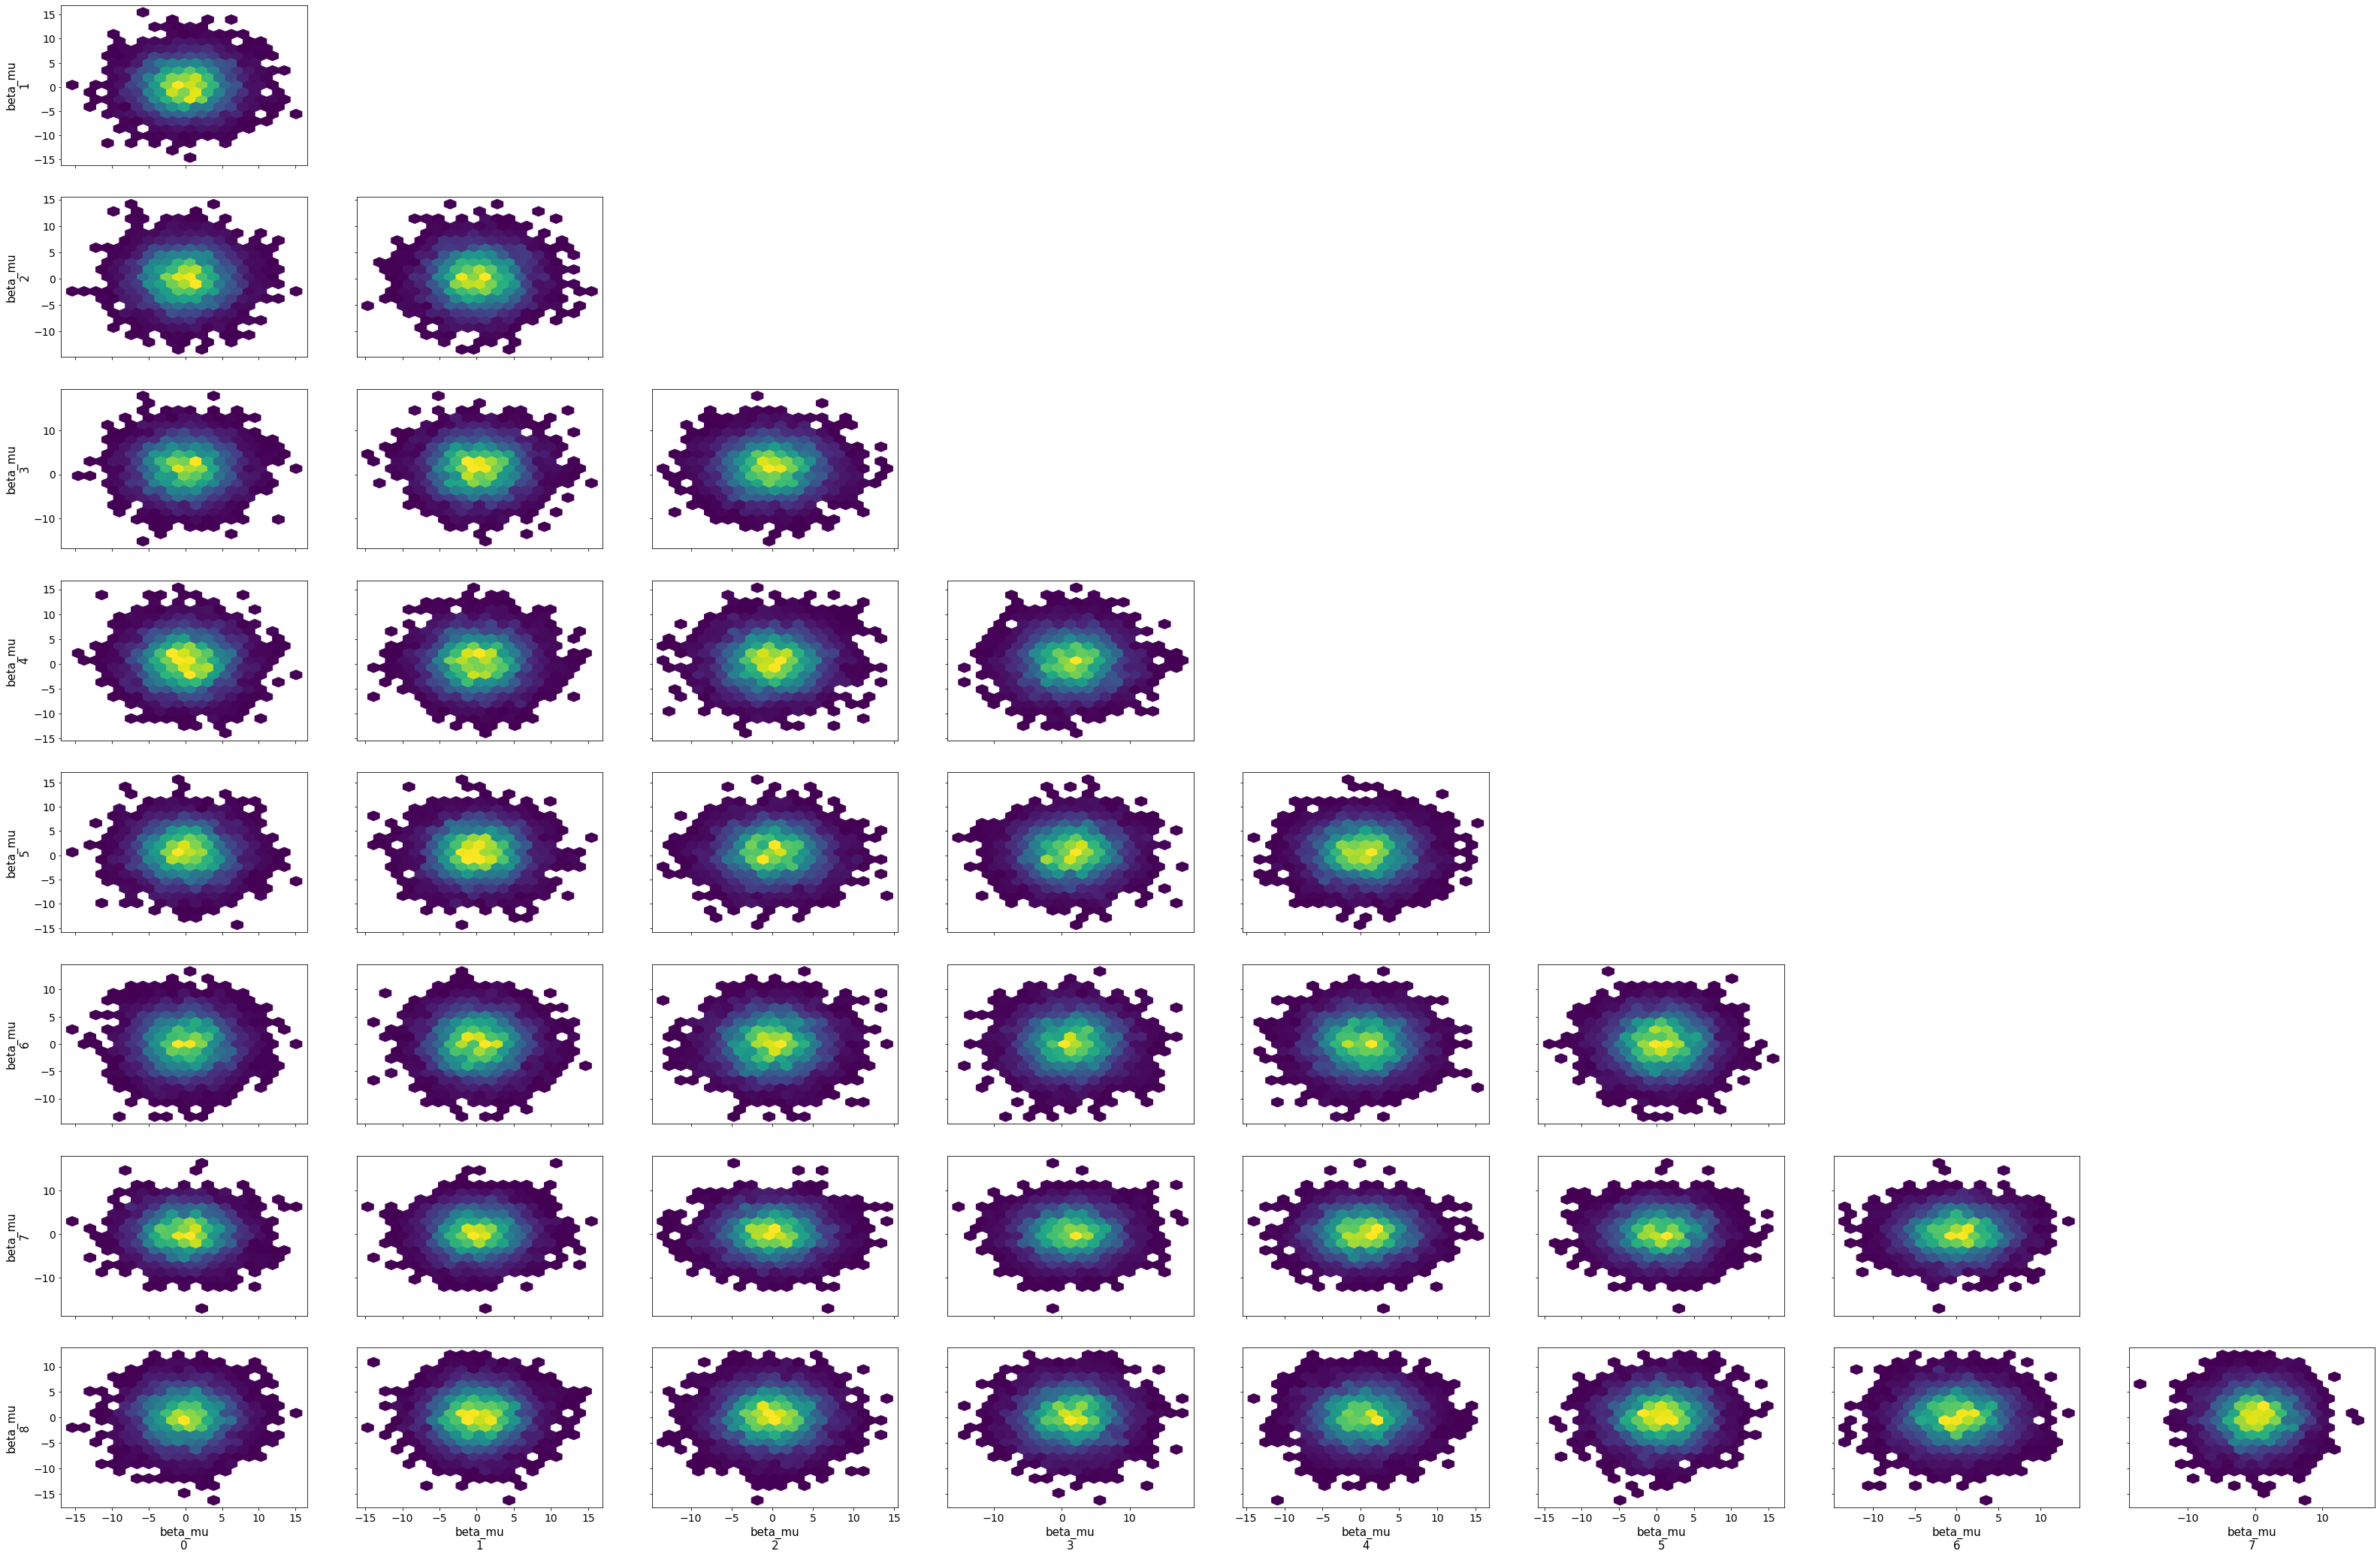

In [82]:
az.plot_pair(trace, kind='hexbin');

In [83]:
X_shared.set_value(X_test)

In [84]:
predictions = pm.sample_posterior_predictive(trace, model=model_3)

100%|██████████| 5000/5000 [00:55<00:00, 89.90it/s] 


In [85]:
predictions_posterior = predictions['y'].T

Text(0.5, 1.0, 'posterior distribution of first 10 predictions')

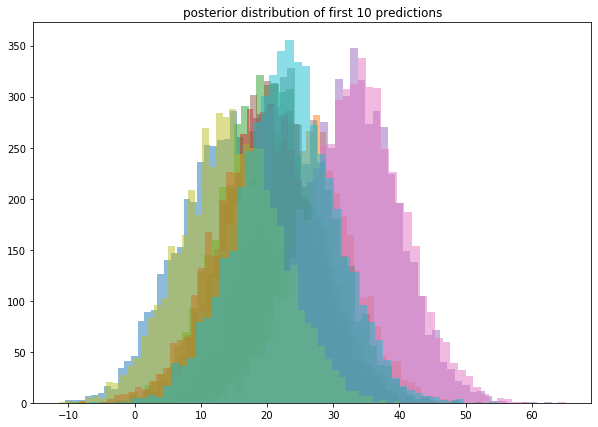

In [86]:
plt.figure(figsize=[10,7])
for x in range(0,10):
    plt.hist(predictions_posterior[x], bins=50, alpha=0.5)
plt.title("posterior distribution of first 10 predictions")

In [87]:
def prediction_intervals(predictions_posterior, percentile):
    predictions = np.array([np.mean(each) for each in predictions_posterior])
    err_down = np.array([np.percentile(each, (100 - percentile) / 2) for each in predictions_posterior])
    err_up = np.array([np.percentile(each, 100 - (100 - percentile) / 2) for each in predictions_posterior])
    return np.transpose(np.array([predictions, err_down, err_up]))

In [88]:
prediction_ints = prediction_intervals(predictions_posterior, percentile=95)

In [89]:
prediction_ints_df = pd.DataFrame(prediction_ints)
prediction_ints_df.columns = ["PREDICTION","LOWER","UPPER"]

In [90]:
actual_prediction_df = pd.DataFrame({'ACTUAL' : y_test}).reset_index(drop=True)

In [91]:
results_df = pd.concat([actual_prediction_df, prediction_ints_df], axis=1)

In [92]:
results_df

ACTUAL  PREDICTION      LOWER      UPPER
0      16.5   13.648696  -0.897805  27.996592
1      24.8   24.703428  10.225129  39.138348
2      17.4   20.024431   5.893497  34.165787
3      19.3   19.510784   4.505928  34.638822
4      37.6   32.744194  18.580569  46.545858
..      ...         ...        ...        ...
97     50.0   30.141943  15.003366  44.794393
98     11.8   10.853895  -3.340336  25.135028
99     19.5   22.950407   9.161701  36.728711
100     8.7    4.355043 -10.337156  18.915401
101    23.3   22.880343   8.324853  37.099083

[102 rows x 4 columns]

In [93]:
r2_score(results_df.ACTUAL, results_df.PREDICTION)

0.5631166956358364

In [94]:
results_df_sorted = results_df.sort_values(by='ACTUAL').reset_index(drop=True)

(0, 60)

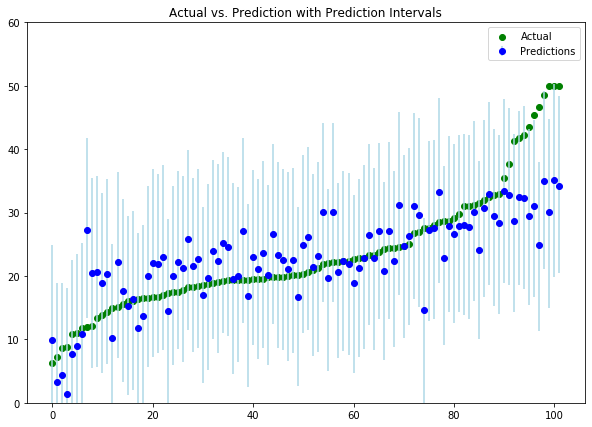

In [95]:
plt.figure(figsize=[10,7])
plt.scatter(results_df_sorted.index,
            results_df_sorted.ACTUAL,
            color='green')
plt.errorbar(results_df_sorted.index,
             results_df_sorted.PREDICTION,
             yerr=[results_df_sorted.PREDICTION - results_df_sorted.LOWER, 
                   results_df_sorted.UPPER - results_df_sorted.PREDICTION],
             ecolor='lightblue', 
             fmt='bo',
             elinewidth=0)
plt.title("Actual vs. Prediction with Prediction Intervals")
plt.legend(['Actual','Predictions'])
plt.ylim([0,60])

In [96]:
correct = 0
for each_row in results_df.itertuples():
    if each_row.LOWER <= each_row.ACTUAL <= each_row.UPPER:
        correct += 1
print(correct/results_df.shape[0])

0.9411764705882353
